In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle
import keras.backend as K

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

In [4]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

In [5]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])
get_stn_output_v2 = K.function([model.layers[0].input], [model.layers[1].output])
stn_weight = model.layers[1].get_weights()

In [6]:
def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27) # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

pos_y11 = (11, 27, 9, 21)

In [7]:
def stn_transform(stn_func, x, batch_size=512):
    
    out = np.zeros_like(x)
    n_step = np.ceil(len(x) / float(batch_size)).astype(np.int32)
    for step in range(n_step):
        start = step * batch_size
        end = (step + 1) * batch_size
        out[start:end] = stn_func([x[start:end], 0])[0]*0.5 + 0.5
    return out

In [8]:
X_train_bal, y_train_bal = gen_balance_data(X_train, y_train, [14], r=1)
y_train_bal = y_train_bal[:, np.newaxis]
X_val_bal, y_val_bal = gen_balance_data(X_val, y_val, [14], r=1)
y_val_bal = y_val_bal[:, np.newaxis]
X_test_bal, y_test_bal = gen_balance_data(X_test, y_test, [14], r=1)
y_test_bal = y_test_bal[:, np.newaxis]

y_test_stn = np.zeros([len(y_test), 1])
y_test_stn[np.where(y_test == 14)] = 1

In [ ]:
import logging
from cleverhans.utils import set_log_level
from cleverhans.utils_keras import KerasModelWrapper

n_attack = 250
ind_1 = np.where(y_test == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

---
# 1

In [11]:
from feat_net import FeatNet

featnet = FeatNet([32, 32, 3], [1], [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-3, save_path="model/featnet.ckpt",
                  stn_weight=stn_weight)

In [12]:
data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.2848
STEP: 50 	Loss: 0.0811
STEP: 100 	Loss: 0.0681
STEP: 150 	Loss: 0.0570
STEP: 200 	Loss: 0.0471
STEP: 250 	Loss: 0.0430
STEP: 300 	Loss: 0.0407
STEP: 350 	Loss: 0.0355
STEP: 400 	Loss: 0.0302
STEP: 450 	Loss: 0.0260
STEP: 500 	Loss: 0.0271
Train Acc|Loss:	0.9998|0.0002
Val Acc|Loss:	0.9993|0.0007
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.0223
STEP: 50 	Loss: 0.0232
STEP: 100 	Loss: 0.0204
STEP: 150 	Loss: 0.0187
STEP: 200 	Loss: 0.0170
STEP: 250 	Loss: 0.0165
STEP: 300 	Loss: 0.0146
STEP: 350 	Loss: 0.0122
STEP: 400 	Loss: 0.0121
STEP: 450 	Loss: 0.0104
STEP: 500 	Loss: 0.0088
Train Acc|Loss:	1.0000|0.0000
Val Acc|Loss:	0.9993|0.0007
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0096
STEP: 50 	Loss: 0.0093
STEP: 100 	Loss: 0.0089
STEP: 150 	Loss: 0.0078
STEP: 200 	Loss: 0.0066
STEP: 250 	Loss: 0.0070
STEP: 300 	Loss: 0.0063
STEP: 350 	Loss: 0.0063
STEP: 400 	Loss: 0.0053
STEP: 450 	Loss: 0.0045
STEP: 500 	Los

In [13]:
featnet.eval_model(sess, (X_train_stn, y_train_stn))

(1.0, 0.0)

In [14]:
featnet.eval_model(sess, (X_val_stn, y_val_stn))

(0.9993197278911564, 0.0006802721088435374)

In [15]:
y = featnet.predict_model(sess, X_val_stn)

y_thres = y >= 0.5
print(np.mean(y_thres[y_val == 14]))

0.9666666666666667


[0.] [1.] [2.5513928e-27] [2.940074e-36]
[0.02779884]


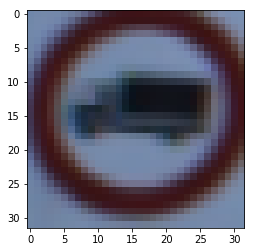

[0.] [1.] [3.1644036e-33] [3.3142637e-28]
[0.02779884]


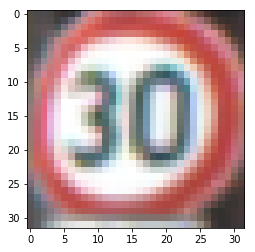

[0.] [1.] [8.334831e-34] [1.4652672e-31]
[0.02779884]


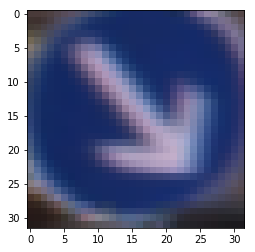

[0.] [1.] [3.148407e-37] [1.2362884e-35]
[0.02779884]


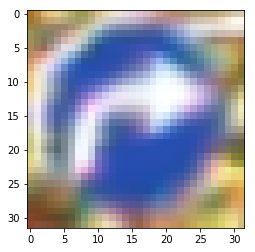

[0.] [1.] [2.5943347e-09] [1.5105742e-17]
[0.02779884]


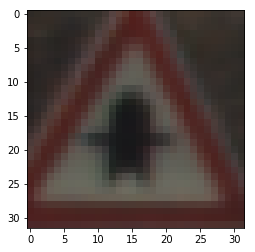

[0.] [1.] [1.4359327e-26] [6.162462e-25]
[0.02779884]


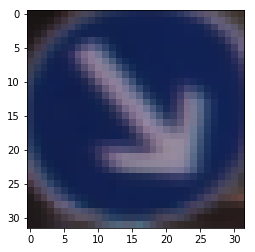

[0.] [1.] [4.2753734e-26] [0.]
[0.02779884]


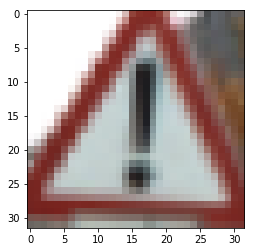

[0.] [1.] [4.1452765e-13] [1.0620435e-17]
[0.02779884]


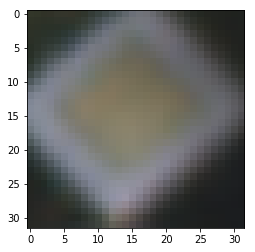

[0.] [1.] [9.766915e-35] [0.]
[0.02779884]


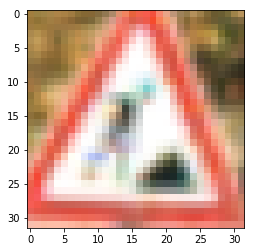

[0.] [1.] [2.3951624e-23] [1.2329151e-22]
[0.02779884]


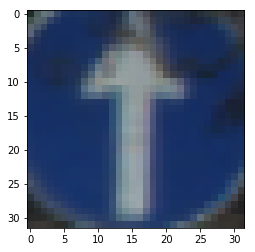

In [16]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[:10]})

for i, x in enumerate(X_test_stn[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.] [2.9858758e-05] [1.] [0.9999999]
[0.9798095]


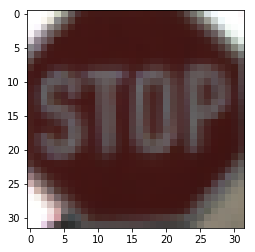

[0.] [3.168833e-09] [1.] [1.]
[0.9798109]


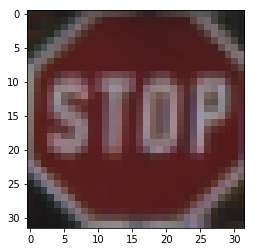

[0.] [6.6954167e-06] [0.9999999] [0.9998247]
[0.97980255]


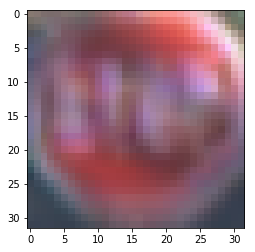

[0.] [3.2682128e-13] [1.] [1.]
[0.9798109]


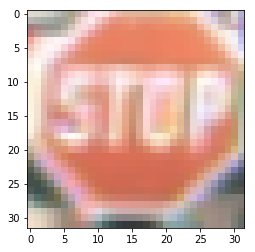

[0.] [2.3055331e-07] [1.] [1.]
[0.9798109]


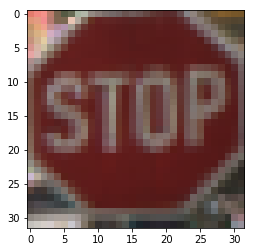

[0.] [4.1914078e-07] [1.] [1.]
[0.9798108]


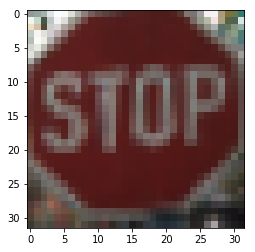

[0.] [6.0532705e-07] [1.] [1.]
[0.9798108]


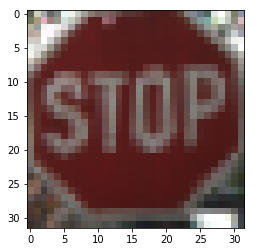

[0.] [3.253897e-07] [1.] [1.]
[0.9798109]


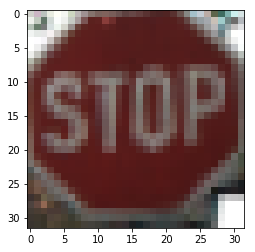

[0.] [8.6866254e-07] [1.] [1.]
[0.9798108]


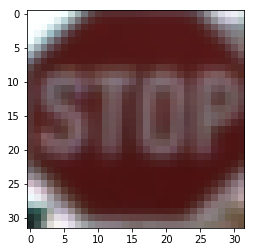

[0.] [1.8514738e-05] [1.] [0.9999994]
[0.97981]


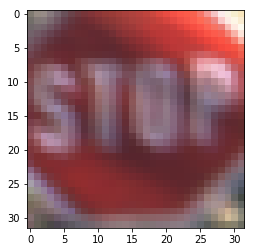

In [17]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})

for i, x in enumerate(X_test_stn[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

In [20]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="featnet")

[<tf.Variable 'featnet/conv2d_14/kernel:0' shape=(3, 3, 3, 16) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_14/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_15/kernel:0' shape=(3, 3, 16, 32) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_15/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_16/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_16/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_4/kernel:0' shape=(3520, 128) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_4/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_5/kernel:0' shape=(128, 32) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_5/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_6/kernel:0' shape=(32, 1) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_6/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_17/kernel:0' shape=(3, 3, 3, 16) dtype=float32_ref>,
 <t

In [25]:
var = [v for v in tf.trainable_variables() if "featnet_1/final_layer/dense_28/" in v.name]
sess.run(var)

[array([[ 1.9298517],
        [-2.27757  ],
        [ 2.85937  ],
        [ 2.2998435]], dtype=float32), array([-1.2769985], dtype=float32)]

---
# 2

In [28]:
from feat_net import FeatNet

featnet = FeatNet([32, 32, 3], [1], [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-3, save_path="model/featnet_v2.ckpt",
                  stn_weight=stn_weight)

In [29]:
data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.2593
STEP: 50 	Loss: 0.2380
STEP: 100 	Loss: 0.2300
STEP: 150 	Loss: 0.2105
STEP: 200 	Loss: 0.2032
STEP: 250 	Loss: 0.1884
STEP: 300 	Loss: 0.1760
STEP: 350 	Loss: 0.1654
STEP: 400 	Loss: 0.1651
STEP: 450 	Loss: 0.1497
STEP: 500 	Loss: 0.1421
Train Acc|Loss:	0.9798|0.0202
Val Acc|Loss:	0.9637|0.0363
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.1416
STEP: 50 	Loss: 0.1290
STEP: 100 	Loss: 0.1183
STEP: 150 	Loss: 0.1154
STEP: 200 	Loss: 0.1104
STEP: 250 	Loss: 0.1048
STEP: 300 	Loss: 0.1030
STEP: 350 	Loss: 0.0942
STEP: 400 	Loss: 0.0879
STEP: 450 	Loss: 0.0841
STEP: 500 	Loss: 0.0795
Train Acc|Loss:	0.9990|0.0010
Val Acc|Loss:	0.9977|0.0023
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0754
STEP: 50 	Loss: 0.0764
STEP: 100 	Loss: 0.0705
STEP: 150 	Loss: 0.0674
STEP: 200 	Loss: 0.0670
STEP: 250 	Loss: 0.0639
STEP: 300 	Loss: 0.0613
STEP: 350 	Loss: 0.0562
STEP: 400 	Loss: 0.0525
STEP: 450 	Loss: 0.0547
STEP: 500 	Los

In [30]:
y = featnet.predict_model(sess, X_val_stn)

y_thres = y >= 0.5
print(np.mean(y_thres[y_val == 14]))

0.9888888888888889


[0.06707981] [0.] [0.14784892] [0.]
[0.0680783]


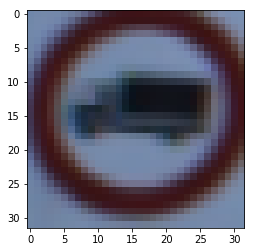

[0.00156881] [0.] [0.00712673] [0.]
[0.0680783]


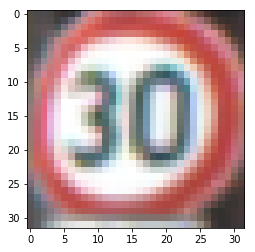

[0.12435373] [0.] [0.03310929] [0.]
[0.0680783]


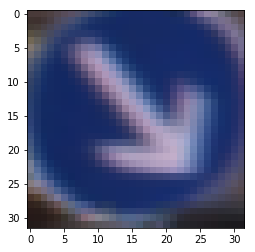

[0.00893375] [0.] [0.00341022] [0.]
[0.0680783]


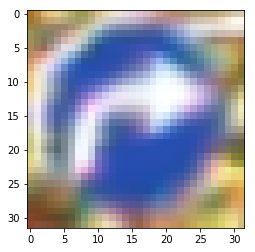

[0.11885143] [1.6888236e-16] [0.1409854] [1.5787735e-18]
[0.0680783]


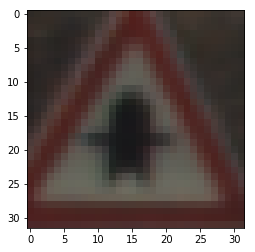

[0.17052336] [0.] [0.06793516] [0.]
[0.0680783]


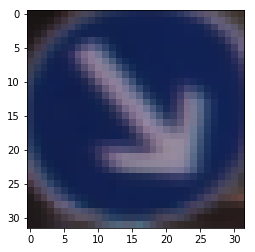

[0.00456791] [0.] [0.03056614] [0.]
[0.0680783]


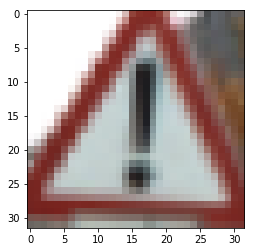

[0.02009718] [0.] [0.03910076] [4.1794796e-31]
[0.0680783]


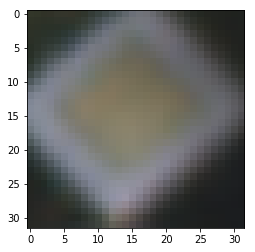

[0.00487472] [0.] [0.00159415] [0.]
[0.0680783]


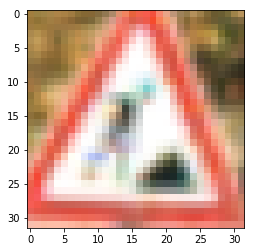

[0.12157124] [0.] [0.02829712] [0.]
[0.0680783]


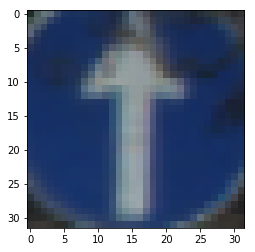

In [31]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[:10]})

for i, x in enumerate(X_test_stn[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.08645595] [1.] [0.12648052] [1.]
[0.94394237]


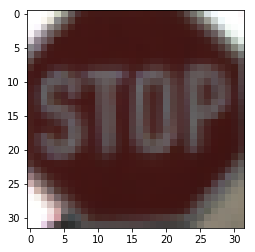

[0.03674234] [1.] [0.07006855] [1.]
[0.94394237]


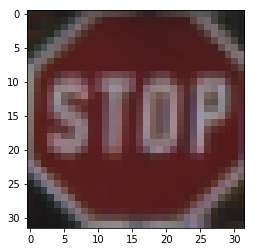

[0.01628668] [1.] [0.02892717] [0.99776316]
[0.94361264]


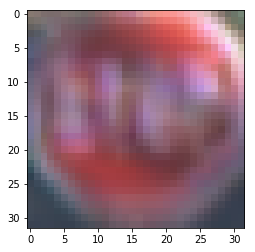

[0.00225788] [1.] [0.00404092] [1.]
[0.94394237]


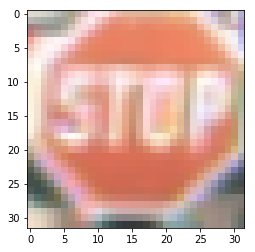

[0.04428295] [1.] [0.08314742] [1.]
[0.94394237]


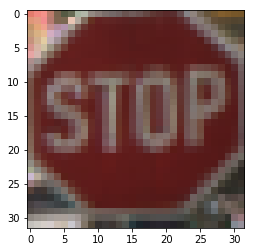

[0.04870374] [1.] [0.09414435] [1.]
[0.94394237]


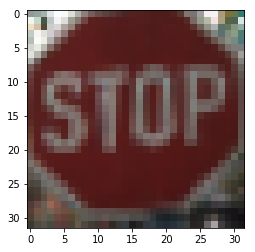

[0.0450777] [1.] [0.08869936] [1.]
[0.94394237]


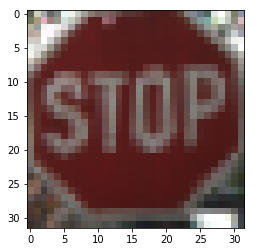

[0.04644004] [1.] [0.08967185] [1.]
[0.94394237]


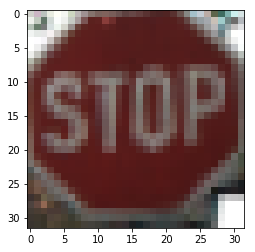

[0.05637848] [1.] [0.09961894] [1.]
[0.94394237]


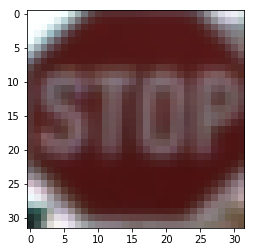

[0.0247838] [1.] [0.0400207] [1.]
[0.94394237]


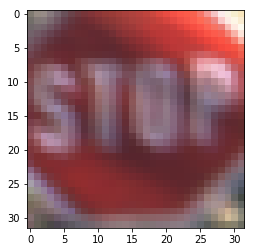

In [32]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})

for i, x in enumerate(X_test_stn[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

In [34]:
var = [v for v in tf.trainable_variables() if "featnet_3/final_layer/" in v.name]
sess.run(var)

[array([[-0.       ],
        [ 2.663234 ],
        [-0.       ],
        [ 2.7770398]], dtype=float32), array([-2.6165903], dtype=float32)]

### Observations

- The network does not use all four features in the decision process

---

# 5

In [14]:
from feat_net import FeatNet

featnet = FeatNet([32, 32, 3], [1], [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-4, save_path="model/featnet.ckpt",
                  stn_weight=stn_weight)

data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.2501
STEP: 50 	Loss: 0.1068
STEP: 100 	Loss: 0.0301
STEP: 150 	Loss: 0.0194
STEP: 200 	Loss: 0.0172
STEP: 250 	Loss: 0.0091
STEP: 300 	Loss: 0.0058
STEP: 350 	Loss: 0.0098
STEP: 400 	Loss: 0.0029
STEP: 450 	Loss: 0.0052
STEP: 500 	Loss: 0.0031
Train Acc|Loss:	0.9989|0.0011
Val Acc|Loss:	0.9986|0.0014
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.0017
STEP: 50 	Loss: 0.0040
STEP: 100 	Loss: 0.0031
STEP: 150 	Loss: 0.0033
STEP: 200 	Loss: 0.0029
STEP: 250 	Loss: 0.0021
STEP: 300 	Loss: 0.0052
STEP: 350 	Loss: 0.0023
STEP: 400 	Loss: 0.0016
STEP: 450 	Loss: 0.0021
STEP: 500 	Loss: 0.0005
Train Acc|Loss:	0.9994|0.0006
Val Acc|Loss:	0.9991|0.0009
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0011
STEP: 50 	Loss: 0.0002
STEP: 100 	Loss: 0.0007
STEP: 150 	Loss: 0.0009
STEP: 200 	Loss: 0.0024
STEP: 250 	Loss: 0.0003
STEP: 300 	Loss: 0.0006
STEP: 350 	Loss: 0.0004
STEP: 400 	Loss: 0.0025
STEP: 450 	Loss: 0.0003
STEP: 500 	Los

In [18]:
y = featnet.predict_model(sess, X_val_stn)

y_thres = y >= 0.5
print(np.mean(y_thres[y_val == 14]))

0.9555555555555556


[1.55835e-09] [8.571906e-24] [4.7917992e-15] [2.2211198e-08]
[5.9423884e-09]


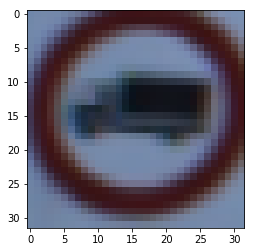

[1.1090537e-13] [5.7751263e-28] [2.6037651e-23] [1.7631248e-10]
[4.4105847e-11]


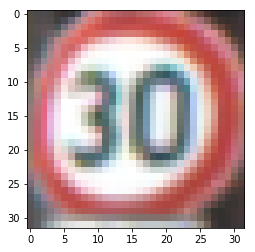

[3.027757e-12] [1.1054923e-18] [6.847927e-12] [2.6211413e-11]
[9.021775e-12]


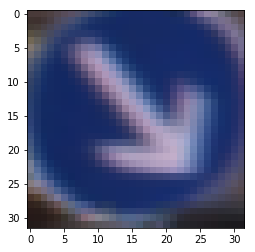

[5.4652663e-17] [2.120777e-28] [5.488904e-22] [3.5198874e-14]
[8.813382e-15]


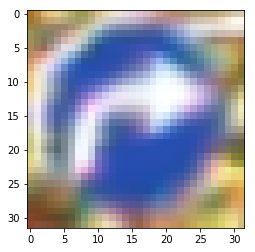

[6.2975385e-05] [4.8658073e-09] [2.5770895e-08] [0.00022278]
[7.144612e-05]


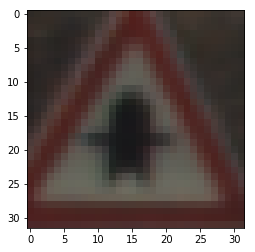

[2.463369e-10] [5.3555174e-15] [7.069696e-09] [5.245561e-09]
[3.1403997e-09]


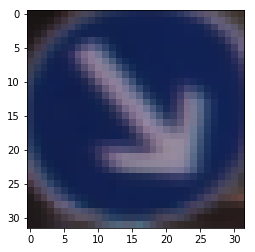

[2.0363341e-11] [2.781902e-25] [5.2628195e-16] [2.3962642e-07]
[5.991169e-08]


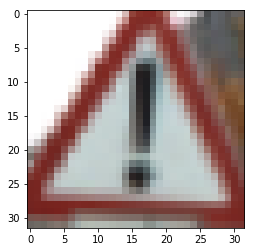

[1.0492296e-10] [8.00921e-17] [5.7422074e-13] [1.8208926e-08]
[4.5786055e-09]


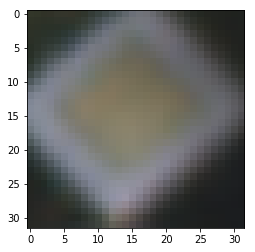

[1.5267301e-11] [3.8571733e-28] [9.742918e-19] [6.8239463e-09]
[1.7098034e-09]


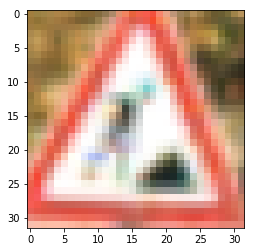

[1.3251154e-12] [1.03564746e-22] [4.5606782e-15] [5.7444876e-09]
[1.4364543e-09]


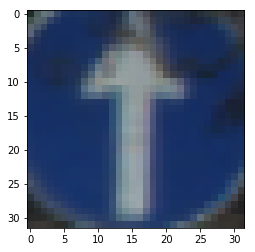

In [16]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[:10]})

for i, x in enumerate(X_test_stn[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.99999416] [0.9999212] [0.99997425] [0.99985945]
[0.9999373]


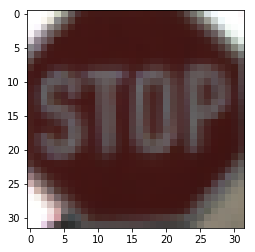

[0.99999976] [0.9999987] [0.99999964] [1.]
[0.9999995]


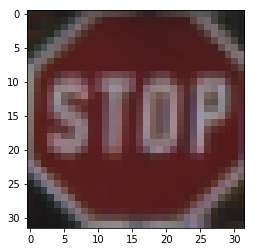

[0.98385644] [0.999998] [0.99999106] [0.9999702]
[0.9959539]


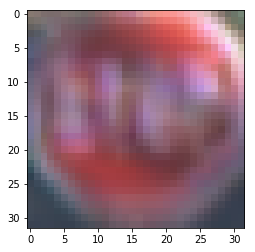

[0.9861432] [0.99999964] [1.] [0.99991596]
[0.9965147]


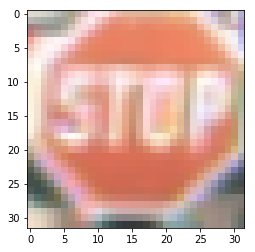

[0.99999964] [0.999997] [0.99999845] [0.9999962]
[0.99999785]


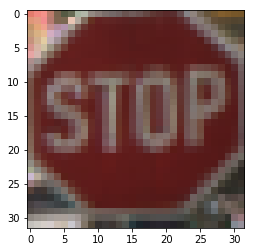

[0.9999993] [0.99999607] [0.9999939] [0.9976361]
[0.99940634]


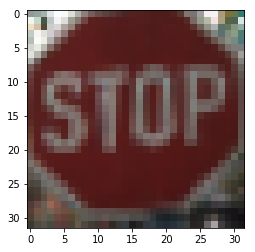

[0.99999964] [0.99999475] [0.99999714] [0.9996649]
[0.9999141]


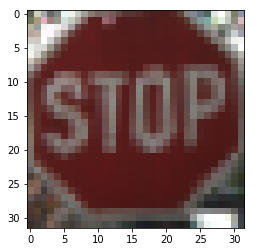

[0.99999964] [0.9999958] [0.9999963] [0.99974054]
[0.99993306]


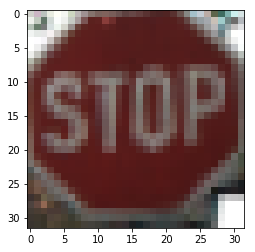

[0.9999993] [0.9999819] [0.9999931] [0.9999999]
[0.99999356]


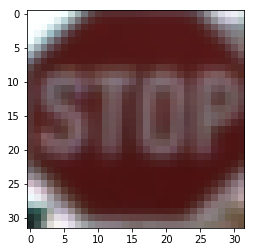

[0.9999987] [0.9999969] [0.9999999] [0.9999999]
[0.9999988]


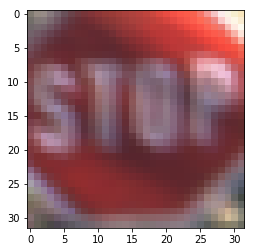

In [17]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})

for i, x in enumerate(X_test_stn[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.55785596] [0.08812795] [0.17644197] [5.876988e-06]
[0.20560795]


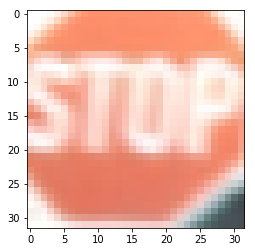

[0.00087485] [0.99971336] [0.0631621] [0.1899125]
[0.3134157]


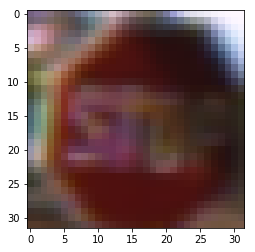

In [24]:
y = featnet.predict_model(sess, X_test_stn[y_test == 14])
ind = np.where(y < 0.5)[0]

scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][ind]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][ind]})

for i, x in enumerate(X_test_stn[y_test == 14][ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

- The representations are disentangled so the network presumably learns the features
- However, the feature scores does not indicate the quality of the features
    - We want the final score to be meaningful which can come from the feature scores being meaningful
    - Hinge loss possibly helps... can be used to set threshold of voting
- How to deal with features that appear in multiple classes (like '0')?
    - Manually group in the training set --> break the end-to-end scheme, need to train the feature detectors "separately"
- Philosophical question: how should the features be selected? 
    - Choose by semantic meanings determined by humans? E.g. ask people what do you think X needs to have to be considered a stop sign
        - This is straightforward and robust but not end-to-end
    - Even cooler: let network decides and see if they match with human's choices
        - This is where interpretable ML can come into play
    
# Goals

0. Good clean accuracy
1. Features are robustly detect (interpretability of feature scores is nice to have but doesn't actually matter at this stage)  
    - The main concept is still that "easy task is easy to make robust"
2. No single area/feature of the image that dominates the decision. This is achieved by:
    - Masking and separating streams
    - Use sigmoid to limit contribution of each feature

--- 

# 6

In [10]:
from feat_net import FeatNet

featnet = FeatNet([32, 32, 3], [1], [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-4, save_path="model/featnet.ckpt",
                  stn_weight=stn_weight)

data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: -9.7533
STEP: 50 	Loss: -102.3688
STEP: 100 	Loss: -198.9342
STEP: 150 	Loss: -182.8638
STEP: 200 	Loss: -169.5470
STEP: 250 	Loss: -196.9396
STEP: 300 	Loss: -194.7798
STEP: 350 	Loss: -203.9156
STEP: 400 	Loss: -187.3342
STEP: 450 	Loss: -209.7224
STEP: 500 	Loss: -177.2811
Train Acc|Loss:	0.9914|0.0086
Val Acc|Loss:	0.9843|0.0157
============= EPOCH: 1 =============
STEP: 0 	Loss: -210.7617
STEP: 50 	Loss: -213.2940
STEP: 100 	Loss: -190.7038
STEP: 150 	Loss: -183.8746
STEP: 200 	Loss: -187.3213
STEP: 250 	Loss: -172.5353
STEP: 300 	Loss: -196.4070
STEP: 350 	Loss: -190.2949
STEP: 400 	Loss: -211.6466
STEP: 450 	Loss: -197.9350
STEP: 500 	Loss: -206.0374
Train Acc|Loss:	0.9950|0.0050
Val Acc|Loss:	0.9873|0.0127
============= EPOCH: 2 =============
STEP: 0 	Loss: -185.8571
STEP: 50 	Loss: -194.0864
STEP: 100 	Loss: -176.9302
STEP: 150 	Loss: -181.9420
STEP: 200 	Loss: -187.1022
STEP: 250 	Loss: -155.9460
STEP: 300 	Loss: -211.4507
S

In [21]:
y = featnet.predict_model(sess, X_val_stn)

y_thres = y >= (4*0.75)
print(np.mean(y_thres[y_val_stn == 1]))

0.805324074074074


[1.9698041e-20] [6.190385e-24] [1.7105225e-18] [7.341306e-19]
[2.464364e-18]


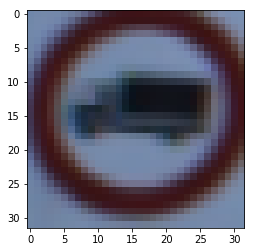

[8.923833e-28] [2.586556e-33] [6.7417885e-30] [6.130052e-20]
[6.130052e-20]


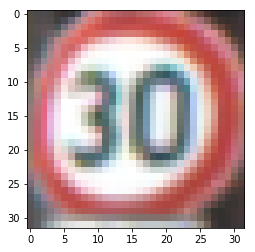

[5.566764e-19] [7.0879137e-19] [1.7000329e-22] [2.0141354e-33]
[1.2656378e-18]


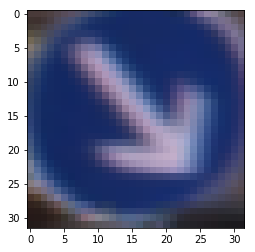

[6.3738493e-37] [2.736322e-30] [1.8917507e-26] [1.08649715e-36]
[1.8920319e-26]


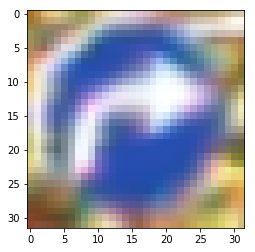

[1.2129823e-09] [1.0787294e-09] [1.2261715e-09] [3.17165e-07]
[3.2068286e-07]


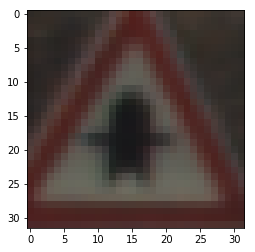

[1.042079e-15] [7.881408e-15] [3.1240094e-17] [8.3755296e-27]
[8.954727e-15]


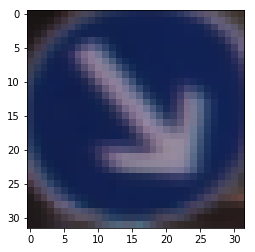

[1.7204869e-28] [6.586814e-32] [3.650658e-21] [2.3512098e-13]
[2.3512098e-13]


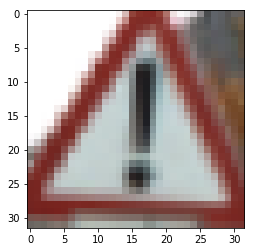

[3.4894918e-22] [2.9348494e-23] [1.4507708e-19] [2.6400377e-18]
[2.785493e-18]


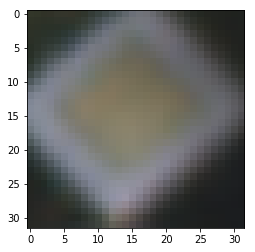

[5.4278515e-23] [3.790376e-32] [4.447501e-33] [3.3087229e-18]
[3.308777e-18]


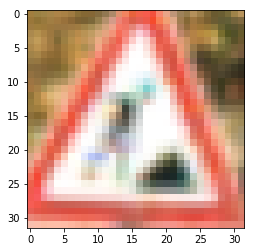

[1.8892028e-21] [1.8673612e-24] [3.0592436e-23] [7.301784e-27]
[1.92167e-21]


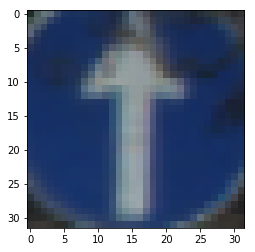

In [13]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[:10]})

for i, x in enumerate(X_test_stn[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.9999881] [0.9996811] [0.9999356] [0.99924767]
[3.9988525]


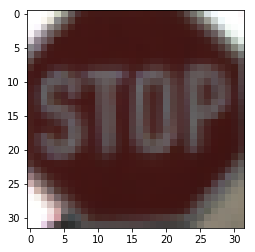

[0.9999999] [0.99999654] [0.99999976] [0.9999856]
[3.9999819]


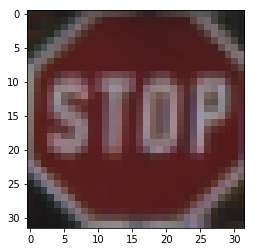

[1.] [0.999998] [0.99999154] [1.8836568e-07]
[2.9999897]


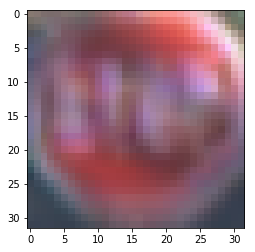

[0.79119277] [1.] [1.] [0.9995621]
[3.7907548]


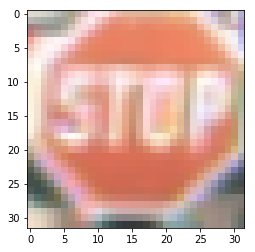

[0.99999917] [0.9999888] [0.99999785] [0.9992398]
[3.9992256]


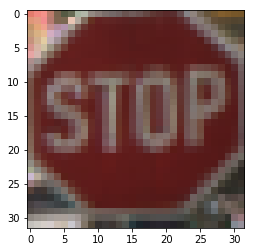

[0.99999857] [0.99998105] [0.99998593] [0.991968]
[3.9919333]


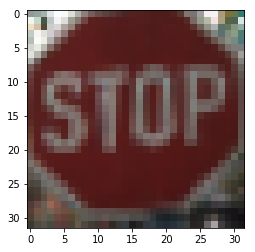

[0.99999964] [0.9999788] [0.9999964] [0.99908173]
[3.9990566]


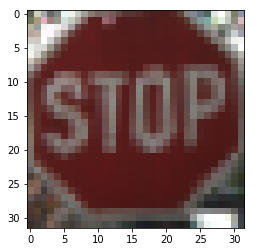

[0.9999993] [0.99998105] [0.99999475] [0.99801093]
[3.9979858]


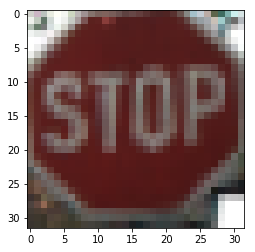

[0.99999774] [0.9999491] [0.99999344] [0.99991786]
[3.9998581]


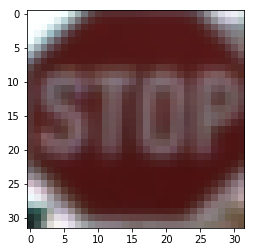

[0.9999969] [0.99999154] [0.9999995] [0.9999944]
[3.9999824]


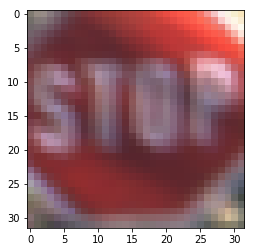

In [14]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})

for i, x in enumerate(X_test_stn[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[2.7404665e-13] [0.0009693] [1.9934185e-09] [1.0628843e-06]
[0.00097036]


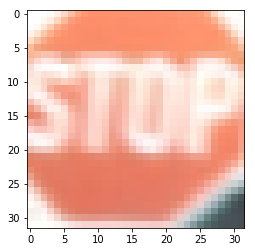

In [15]:
y = featnet.predict_model(sess, X_test_stn[y_test == 14])
ind = np.where(y < 0.5)[0]

scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][ind]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][ind]})

for i, x in enumerate(X_test_stn[y_test == 14][ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.22543047] [7.577896e-07] [1.07983796e-11] [0.20952116]
[0.43495238]


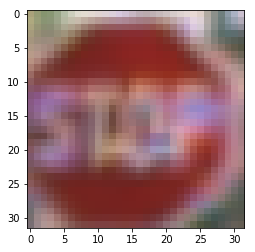

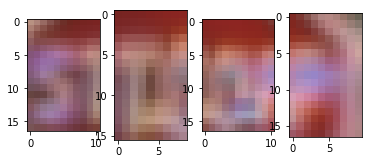

[0.99999464] [0.9990246] [0.9892042] [0.00187154]
[2.9900951]


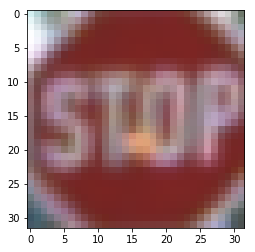

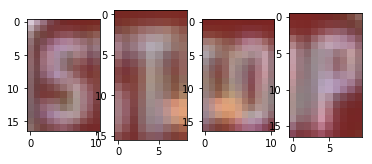

[0.00037602] [0.978456] [0.9983687] [0.99999404]
[2.9771948]


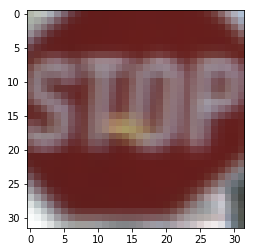

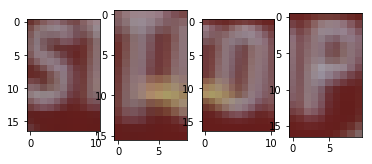

[1.] [0.999998] [1.9601395e-15] [0.0055077]
[2.0055056]


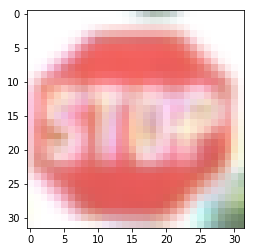

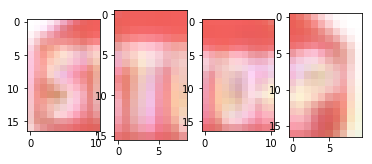

[3.163334e-07] [8.539087e-06] [3.8586145e-06] [0.00272572]
[0.00273844]


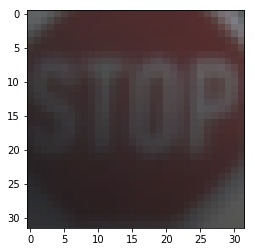

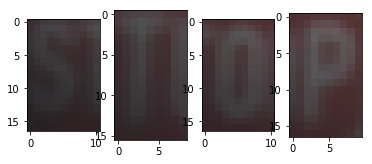

[0.1769141] [0.08789995] [0.00695524] [2.3692248e-10]
[0.2717693]


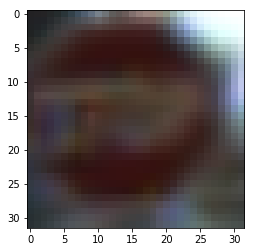

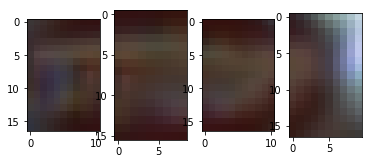

[0.99911433] [0.21505718] [0.15445323] [0.99978215]
[2.3684068]


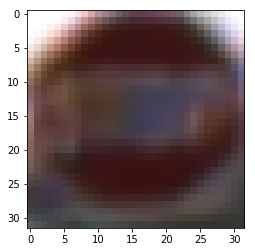

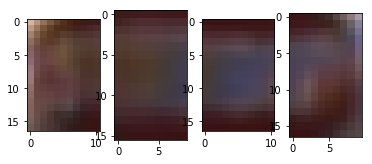

[0.9565052] [0.00926319] [0.0844963] [0.9994966]
[2.0497613]


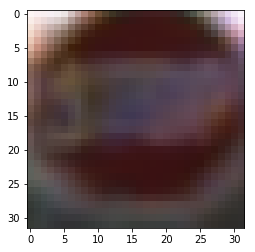

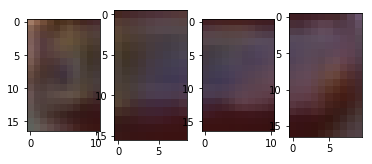

[0.998835] [0.01434289] [0.527647] [0.00631528]
[1.5471401]


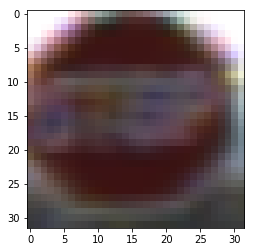

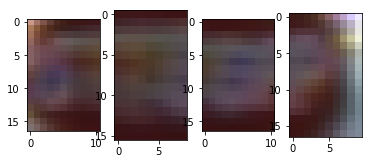

[0.03323227] [0.21347664] [0.01659684] [0.98809975]
[1.2514055]


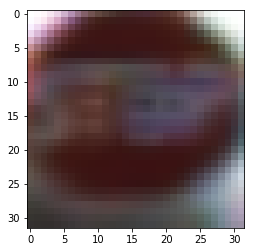

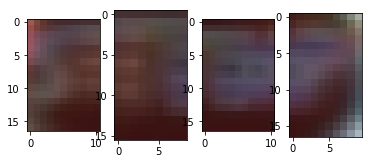

[0.99957174] [0.96220887] [0.70996255] [0.01275059]
[2.6844935]


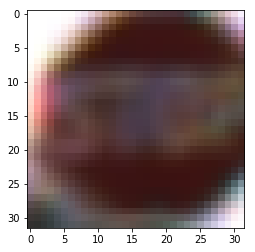

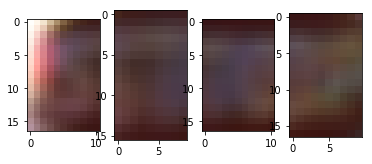

[0.00069927] [0.45796573] [0.07833669] [0.99458647]
[1.5315882]


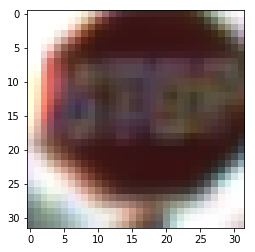

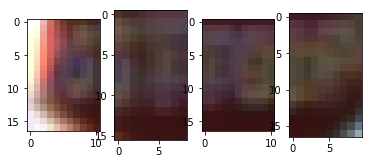

[0.9988887] [0.9997081] [0.9988575] [4.9297725e-08]
[2.9974544]


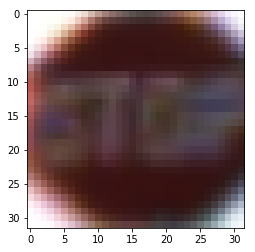

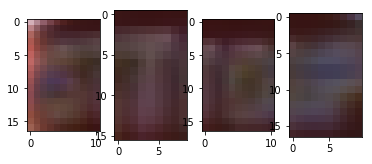

[0.3856039] [0.9540012] [0.03341772] [0.9933123]
[2.3663352]


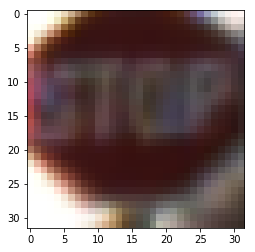

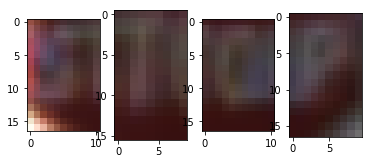

[9.3653514e-05] [0.02637754] [0.00023979] [0.9918305]
[1.0185415]


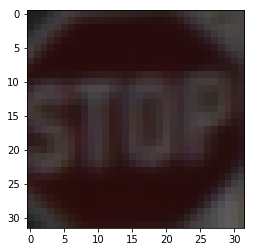

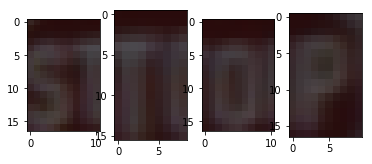

[1.2509937e-05] [0.6636615] [0.9430077] [0.9895605]
[2.5962422]


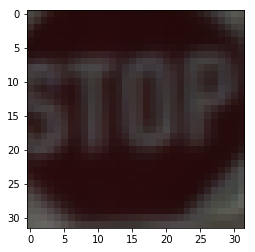

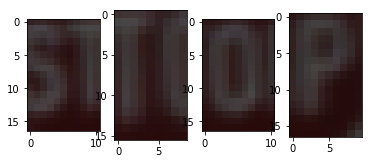

[0.4566545] [0.8888675] [0.20524259] [0.996391]
[2.5471554]


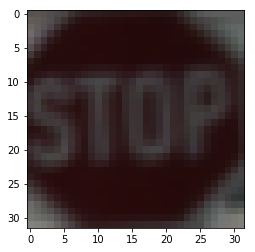

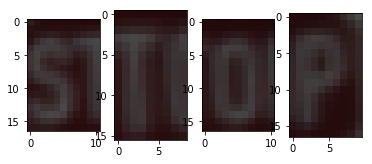

In [32]:
X = X_val[y_val == 14]
X = get_stn_output([X, 0])[0]*0.5 + 0.5
y = featnet.predict_model(sess, X)
ind = np.where(y < 4*0.75)[0]

S = get_patch(X, pos_S)
T = get_patch(X, pos_T)
O = get_patch(X, pos_O)
P = get_patch(X, pos_P)

scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X[ind]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X[ind]})

for i, x in enumerate(X[ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[ind][i])
    axs[1].imshow(T[ind][i])
    axs[2].imshow(O[ind][i])
    axs[3].imshow(P[ind][i])
    plt.show()

---

# 7

Same architecture as 8  
Original pos (overlapping)

In [9]:
from feat_net import FeatNet

featnet = FeatNet("featnet_v7", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=5e-4, 
                  save_path="model/featnet_v7.h5",
                  load_model=True,
                  stn_weight=stn_weight)

# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, n_epoch=10, batch_size=128)

In [12]:
featnet.eval_model(sess, (X_test_bal, y_test_bal))

(0.9913025889967637, -1.9727300126768625)

In [11]:
y = featnet.predict_model(sess, X_test_bal)

y_thres = y >= (2.99)
print(np.mean(y_thres[y_test_bal == 1]))
y_thres = y < (2.99)
print(np.mean(y_thres[y_test_bal == 0]))

0.9859223300970874
0.9991909385113269


[0.] [8.8402074e-29] [1.0859276e-32] [0.]
[8.841293e-29]


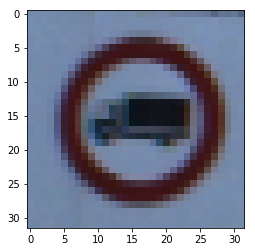

[0.] [0.] [0.] [0.]
[0.]


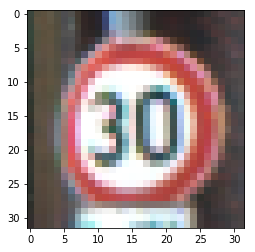

[0.] [1.3103809e-21] [0.] [0.]
[1.3103809e-21]


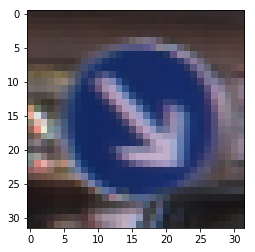

[0.] [2.2162599e-32] [0.] [0.]
[2.2162599e-32]


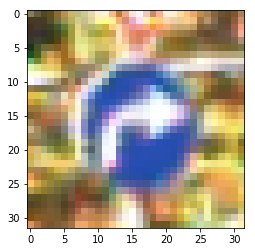

[1.5754726e-23] [1.8922751e-10] [4.5073854e-13] [2.3038595e-14]
[1.8970128e-10]


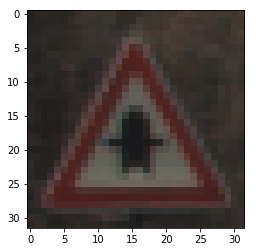

[0.] [1.0243026e-18] [6.461012e-33] [0.]
[1.0243026e-18]


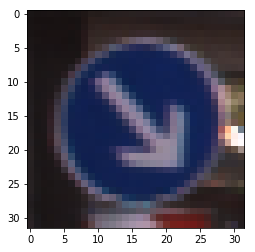

[0.] [1.5032163e-32] [0.] [9.949037e-34]
[1.6027066e-32]


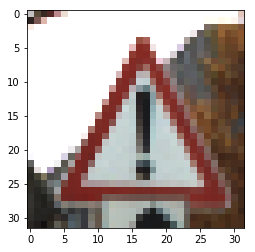

[0.] [1.5684119e-19] [5.6636145e-30] [3.060644e-38]
[1.5684119e-19]


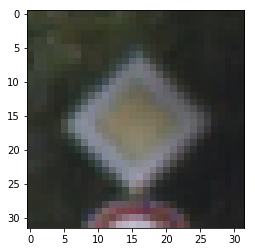

[0.] [4.68102e-34] [0.] [3.3355765e-33]
[3.8036786e-33]


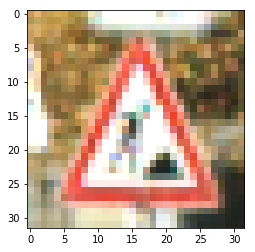

[0.] [1.4063447e-26] [0.] [0.]
[1.4063447e-26]


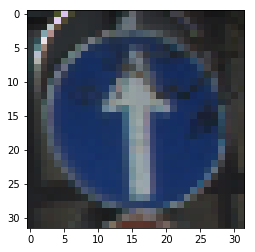

In [12]:
feed_dict = {featnet.model.get_input_at(0): X_test[:10]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X_test[:10]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

for i, x in enumerate(X_test[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.9999784] [0.7323302] [1.1793111e-07] [0.55654114]
[2.2888498]


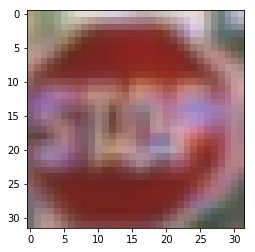

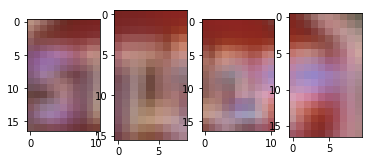

[2.9667648e-09] [0.00133615] [0.99212223] [0.9767244]
[1.9701828]


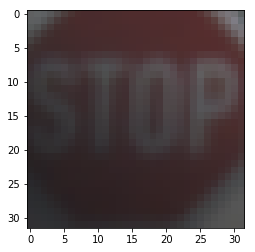

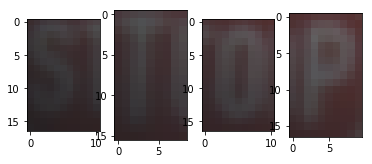

[0.99999] [0.9999223] [0.99938846] [2.7762736e-17]
[2.9993007]


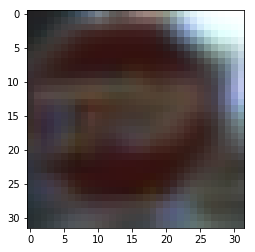

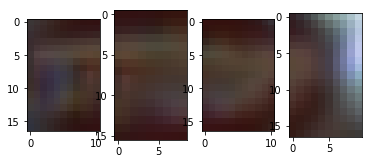

[0.00411681] [0.05610403] [0.8577048] [0.9999908]
[1.9179165]


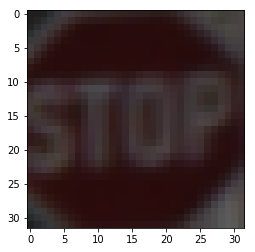

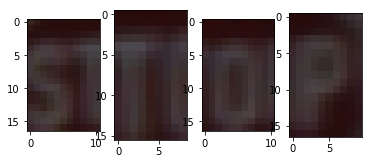

In [14]:
X = X_val[y_val == 14]
y = featnet.predict_model(sess, X)
ind = np.where(y < 4*0.75)[0]

feed_dict = {featnet.model.get_input_at(0): X[ind]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X[ind]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

X = get_stn_output_v2([X])[0]*0.5 + 0.5
S = get_patch(X, pos_S)
T = get_patch(X, pos_T)
O = get_patch(X, pos_O)
P = get_patch(X, pos_P)

for i, x in enumerate(X[ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[ind][i])
    axs[1].imshow(T[ind][i])
    axs[2].imshow(O[ind][i])
    axs[3].imshow(P[ind][i])
    plt.show()

### Test Attack

In [13]:
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
from cleverhans.utils import set_log_level
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
import logging

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Choosing samples to attack
# n_attack = 500
# ind_1 = np.where(np.argmax(y_test, axis=1) == 1)[0]
# ind_14 = np.where(np.argmax(y_test, axis=1) == 14)[0]
# X_atk = np.zeros((n_attack, ) + X_test.shape[1:4])
# X_atk[:n_attack//2] = X_test[ind_1][:n_attack//2]
# X_atk[n_attack//2:] = X_test[ind_14][:n_attack//2]

# y_target = np.zeros((n_attack, ))
# y_target[:n_attack//2] = 14
# y_target[n_attack//2:] = 1
# y_target = to_categorical(y_target, 43)

In [14]:
n_attack = 250
ind_1 = np.where(np.argmax(y_test, axis=1) == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

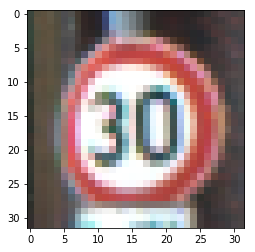

In [15]:
plt.imshow(X_atk[0])

In [16]:
y_pred = model.predict(X_atk)
print("Clean accuracy: ", np.mean(np.argmax(y_pred, axis=1) == 1))
print("Clean acc by featnet: ", np.mean(featnet.predict_model(sess, X_atk) < 3))

Clean accuracy:  1.0
Clean acc by featnet:  1.0


In [39]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.01,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=4*.75, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-26 09:26:40,194 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-10-26 09:26:42,938 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-10-26 09:26:43,317 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-26 09:26:45,692 cleverhans]     Iteration 0 of 500: loss=357 l2=0 loss1=5.89e-10
[DEBUG 2018-10-26 09:26:52,787 cleverhans]     Iteration 50 of 500: loss=35.6 l2=10.9 loss1=3.49
[DEBUG 2018-10-26 09:27:00,086 cleverhans]     Iteration 100 of 500: loss=16 l2=9.71 loss1=3.85
[DEBUG 2018-10-26 09:27:07,468 cleverhans]     Iteration 150 of 500: loss=10.8 l2=7.97 loss1=3.88
[DEBUG 2018-10-26 09:27:14,771 cleverhans]     Iteration 200 of 500: loss=8.47 l2=6.98 loss1=3.82
[DEBUG 2018-10-26 09:27:21,953 cleverhans]     Iteration 250 of 500: loss=7.61 l2=6.53 loss1=3.76
[DEBUG 2018-10-26 09:27:28,974 cleverhans]     Iteration 300 of 500: loss=7.06 l2=6.34 loss1=3.76
[DEBUG 2018-10-26 09:27:35,944 cleverhans]     Iteration 350 of 5

[DEBUG 2018-10-26 09:34:37,905 cleverhans]     Iteration 300 of 500: loss=6.71 l2=5.92 loss1=3.49
[DEBUG 2018-10-26 09:34:45,177 cleverhans]     Iteration 350 of 500: loss=6.19 l2=5.76 loss1=3.5
[DEBUG 2018-10-26 09:34:52,400 cleverhans]     Iteration 400 of 500: loss=5.91 l2=5.63 loss1=3.52
[DEBUG 2018-10-26 09:34:59,568 cleverhans]     Iteration 450 of 500: loss=5.66 l2=5.49 loss1=3.51
[DEBUG 2018-10-26 09:35:06,570 cleverhans]   Successfully generated adversarial examples on 250 of 250 instances.
[DEBUG 2018-10-26 09:35:06,571 cleverhans]    Mean successful distortion: 2.009
[DEBUG 2018-10-26 09:35:06,573 cleverhans]   Binary search step 7 of 10
[DEBUG 2018-10-26 09:35:06,713 cleverhans]     Iteration 0 of 500: loss=196 l2=0 loss1=5.89e-10
[DEBUG 2018-10-26 09:35:13,930 cleverhans]     Iteration 50 of 500: loss=37.3 l2=6.98 loss1=3.31
[DEBUG 2018-10-26 09:35:21,031 cleverhans]     Iteration 100 of 500: loss=15.9 l2=6.97 loss1=3.41
[DEBUG 2018-10-26 09:35:28,184 cleverhans]     Itera

In [33]:
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  1.0
Attack success on featnet:  1.0
Mean successful l-2 dist:  2.274587
Mean successful l-inf dist:  0.28391755


In [16]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=2.99, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-23 21:14:35,703 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-10-23 21:14:37,659 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-10-23 21:14:37,798 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-23 21:14:40,847 cleverhans]     Iteration 0 of 500: loss=178 l2=0 l1=3
[DEBUG 2018-10-23 21:14:47,801 cleverhans]     Iteration 50 of 500: loss=36.9 l2=8.28 l1=2.82
[DEBUG 2018-10-23 21:14:54,752 cleverhans]     Iteration 100 of 500: loss=36.5 l2=8.6 l1=2.76
[DEBUG 2018-10-23 21:15:01,712 cleverhans]     Iteration 150 of 500: loss=36.4 l2=8.92 l1=2.72
[DEBUG 2018-10-23 21:15:08,718 cleverhans]     Iteration 200 of 500: loss=36 l2=8.65 l1=2.71
[DEBUG 2018-10-23 21:15:15,737 cleverhans]     Iteration 250 of 500: loss=36.3 l2=9.5 l1=2.65
[DEBUG 2018-10-23 21:15:15,739 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-23 21:15:15,745 cleverhans]   Successfully generated adversarial examples on 11 of 250 insta

In [21]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 1,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1e9,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=2.99, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-23 22:47:21,250 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-10-23 22:47:23,515 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-10-23 22:47:23,720 cleverhans]   Binary search step 0 of 1
[DEBUG 2018-10-23 22:47:25,855 cleverhans]     Iteration 0 of 500: loss=1.78e+10 l2=0 l1=3
[DEBUG 2018-10-23 22:47:25,856 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-23 22:47:25,862 cleverhans]   Successfully generated adversarial examples on 0 of 250 instances.
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[DEBUG 2018-10-23 22:47:25,864 cleverhans]    Mean successful distortion: nan


In [42]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.3,
              'eps_iter': 0.01,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:716: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-26 09:40:50,670 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [43]:
# (0.3, 0.01, 50)
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  1.0
Attack success on featnet:  0.996
Mean successful l-2 dist:  9.076808
Mean successful l-inf dist:  0.3


In [41]:
# (0.1, 0.01, 50)
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.688
Attack success on featnet:  0.648
Mean successful l-2 dist:  3.7969398
Mean successful l-inf dist:  0.10000003


[1.] [0.9974994] [1.] [0.9486059]
[3.9461055]


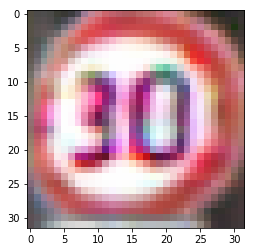

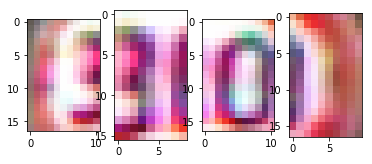

[1.] [1.] [1.] [0.99970883]
[3.999709]


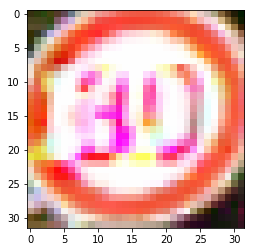

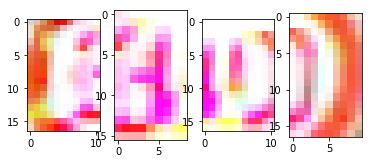

[0.9998921] [0.99124146] [0.33182737] [0.99988246]
[3.3228433]


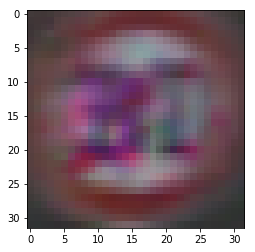

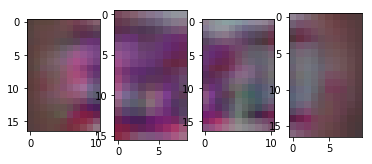

[0.999926] [0.36980632] [1.] [1.]
[3.3697324]


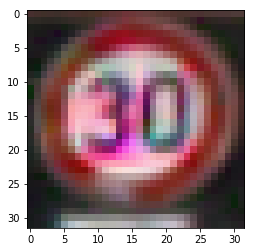

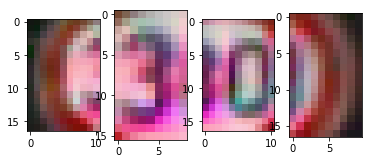

[0.03136521] [0.9999801] [1.] [1.]
[3.0313454]


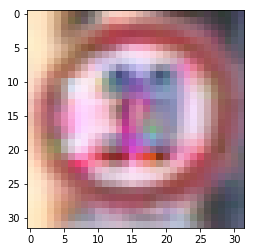

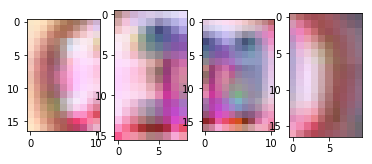

[1.] [0.4644716] [1.] [1.]
[3.4644716]


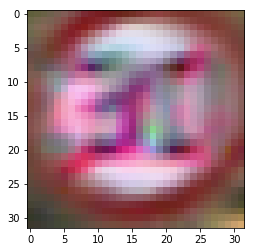

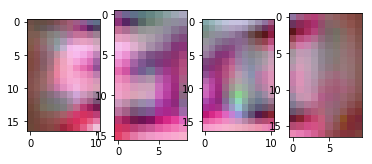

[0.999997] [1.] [1.] [0.3832914]
[3.3832886]


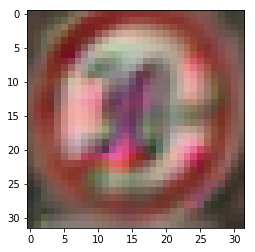

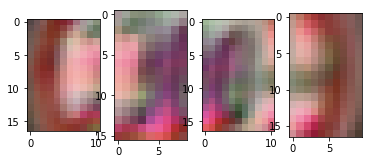

[0.83983576] [1.] [1.] [0.36994895]
[3.2097845]


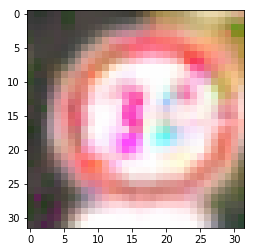

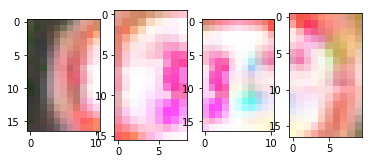

[0.99999857] [0.9999994] [0.9999994] [0.28445184]
[3.284449]


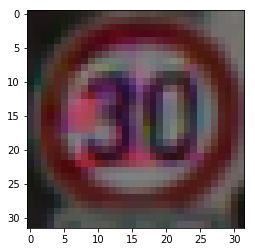

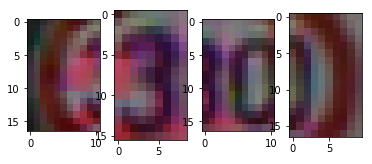

[0.9994586] [1.] [0.9153709] [1.]
[3.9148295]


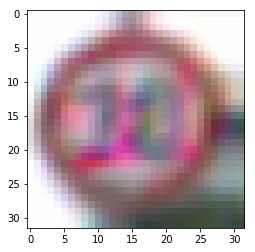

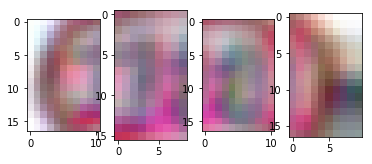

[0.865593] [1.] [1.] [0.9999982]
[3.865591]


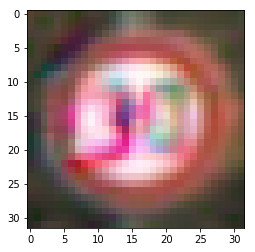

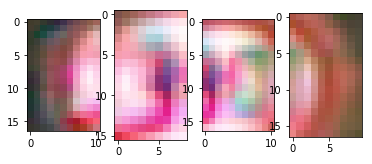

[0.99998415] [0.58792746] [1.] [0.9963152]
[3.5842268]


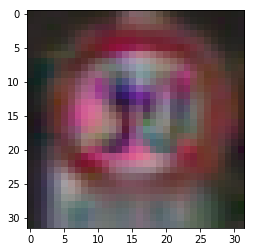

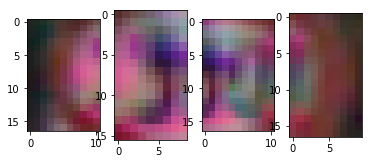

[0.99918133] [1.] [0.9982546] [0.99752337]
[3.994959]


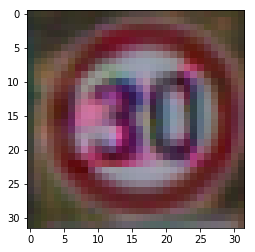

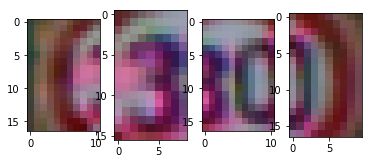

[0.9833348] [0.8391332] [1.] [0.48317444]
[3.3056426]


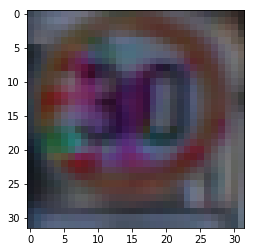

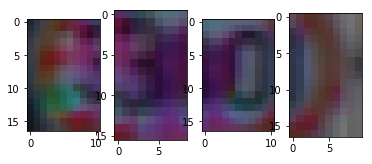

[0.9999999] [0.9667249] [1.] [1.]
[3.9667249]


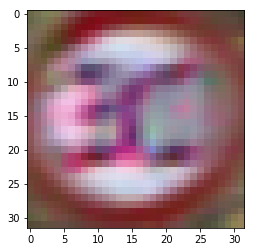

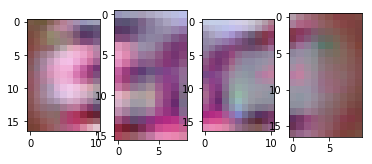

[0.03992274] [1.] [1.] [0.99679834]
[3.036721]


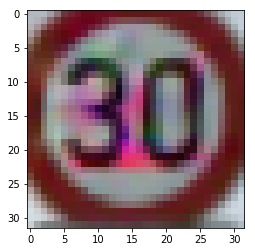

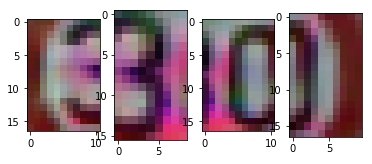

[0.9999994] [1.] [1.] [0.6952289]
[3.6952283]


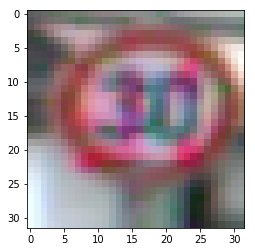

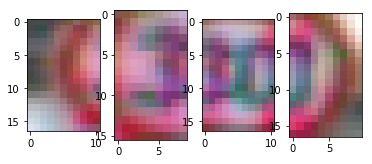

[0.9999974] [0.4767203] [0.9993987] [0.9995215]
[3.475638]


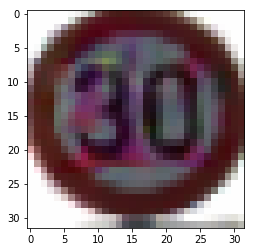

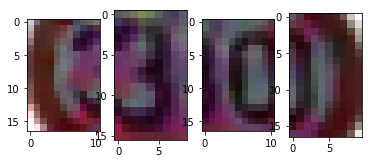

[1.] [1.] [0.566117] [0.87632245]
[3.4424396]


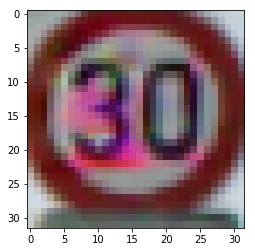

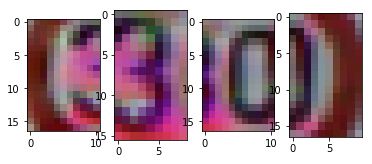

[0.4762113] [1.] [1.] [0.7328971]
[3.2091084]


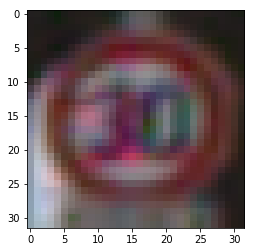

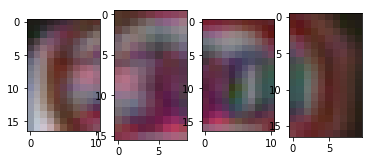

In [29]:
X = adv[:20]
y = featnet.predict_model(sess, X)

feed_dict = {featnet.model.get_input_at(0): X}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

X = get_stn_output_v2([X])[0]*0.5 + 0.5
S = get_patch(X, pos_S)
T = get_patch(X, pos_T)
O = get_patch(X, pos_O)
P = get_patch(X, pos_P)

for i, x in enumerate(X):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[i])
    axs[1].imshow(T[i])
    axs[2].imshow(O[i])
    axs[3].imshow(P[i])
    plt.show()

In [102]:
# Attack on featnet + orig model (L2)

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 5,
              'eps_iter': 0.1,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': 2, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:715: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-23 05:56:56,137 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [103]:
# L2 (5, 0.1, 50)
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.78
Attack success on featnet:  0.036
Mean successful l-2 dist:  4.994739
Mean successful l-inf dist:  0.2689411


In [93]:
# L2 (10, 0.1, 100)
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.98
Attack success on featnet:  0.024
Mean successful l-2 dist:  8.862504
Mean successful l-inf dist:  0.38987744


In [95]:
# L2 (10, 0.1, 100) no rnd
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.864
Attack success on featnet:  0.02
Mean successful l-2 dist:  1.2794199
Mean successful l-inf dist:  0.2162219


In [101]:
# L2 (10, 0.01, 500) no rnd
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.596
Attack success on featnet:  0.012
Mean successful l-2 dist:  1.1092416
Mean successful l-inf dist:  0.19851671


---
# 8

Architecture is changed slightly. First conv layer is removed since the new window is narrower.

In [9]:
from feat_net import FeatNet

pos_S = (7, 24, 0, 9)
pos_T = (7, 23, 9, 15)
pos_O = (6, 23, 15, 23)
pos_P = (6, 23, 23, 32)

featnet = FeatNet("featnet_v8-3", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-4, 
                  save_path="model/featnet_v8-3.h5",
                  load_model=True,
                  stn_weight=stn_weight)

# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, n_epoch=10, batch_size=128)

In [10]:
featnet.eval_model(sess, (X_test_bal, y_test_bal))

(0.9884708737864077, -1.9057788179048056)

In [11]:
scores = featnet.scores(sess, X_test)
print("avg scores (stop): ", np.mean(scores[np.where(y_test == 14)[0]], 0))
print("avg scores (non-stop): ", np.mean(scores[np.where(y_test != 14)[0]], 0))

outputs = np.sum(scores, 1)
print("avg output (stop): ", np.mean(outputs[np.where(y_test == 14)[0]]))
print("avg output (non-stop): ", np.mean(outputs[np.where(y_test != 14)[0]]))

fp = np.sum(y_test[np.where(outputs >= 3)[0]] != 14)
fpr = fp / (fp + np.sum(y_test != 14))
print("FP: ", fpr)
fn = np.sum(y_test[np.where(outputs < 3)[0]] == 14)
fnr = fn / (fn + np.sum(y_test == 14))
print("FN: ", fnr)

avg scores (stop):  [0.9945687  0.99997223 0.98316945 0.8774585 ]
avg scores (non-stop):  [0.02072595 0.01626946 0.00520064 0.00340294]
avg output (stop):  3.8551688767652523
avg output (non-stop):  0.045598984282202965
FP:  0.001696147322510298
FN:  0.021739130434782608


[1.] [1.] [0.10076189] [0.02131977]
[2.1220818]


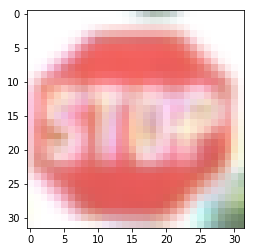

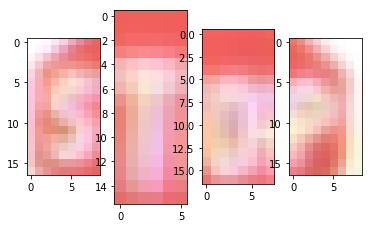

[0.87416273] [0.54446805] [0.48946026] [0.00484825]
[1.9129393]


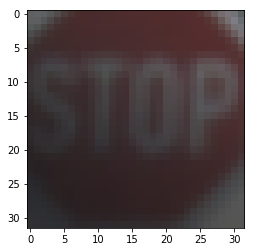

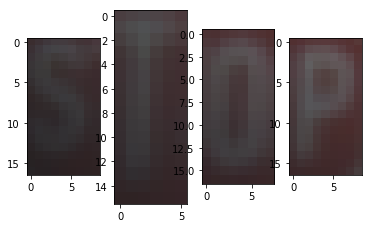

[0.99999785] [0.9998078] [0.9990663] [2.1125007e-13]
[2.998872]


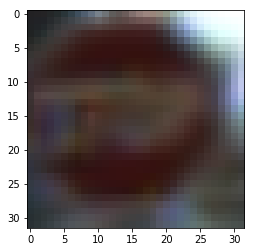

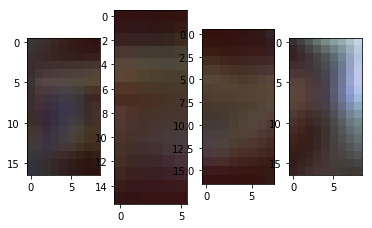

In [35]:
X = X_val[y_val == 14]

y = featnet.predict_model(sess, X)
ind = np.where(y < 4*0.75)[0]

feed_dict = {featnet.model.get_input_at(0): X[ind]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X[ind]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

X = get_stn_output_v2([X])[0]*0.5 + 0.5
S = get_patch(X, pos_S)
T = get_patch(X, pos_T)
O = get_patch(X, pos_O)
P = get_patch(X, pos_P)

for i, x in enumerate(X[ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[ind][i])
    axs[1].imshow(T[ind][i])
    axs[2].imshow(O[ind][i])
    axs[3].imshow(P[ind][i])
    plt.show()

In [85]:
y_pred = model.predict(X_atk)
print("Clean accuracy: ", np.mean(np.argmax(y_pred, axis=1) == 1))
print("Clean acc by featnet: ", np.mean(featnet.predict_model(sess, X_atk) < 3))

Clean accuracy:  1.0
Clean acc by featnet:  1.0


In [91]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 5,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=4*.75, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-26 19:47:00,971 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-10-26 19:47:04,236 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-10-26 19:47:04,694 cleverhans]   Binary search step 0 of 5
[DEBUG 2018-10-26 19:47:07,079 cleverhans]     Iteration 0 of 500: loss=1.53e+03 l2=0 loss1=0.000873
[DEBUG 2018-10-26 19:47:10,093 cleverhans]     Iteration 50 of 500: loss=38.1 l2=38.1 loss1=4
[DEBUG 2018-10-26 19:47:13,229 cleverhans]     Iteration 100 of 500: loss=17.8 l2=17.8 loss1=3.99
[DEBUG 2018-10-26 19:47:16,554 cleverhans]     Iteration 150 of 500: loss=23.6 l2=23.6 loss1=3.95
[DEBUG 2018-10-26 19:47:16,555 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-26 19:47:16,561 cleverhans]   Successfully generated adversarial examples on 250 of 250 instances.
[DEBUG 2018-10-26 19:47:16,563 cleverhans]    Mean successful distortion: 2.956
[DEBUG 2018-10-26 19:47:16,567 cleverhans]   Binary search step 1 of 5
[DEBUG 2

In [ ]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.01,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=4*.75, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-11-07 10:11:47,892 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-11-07 10:11:50,529 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-11-07 10:11:50,796 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-11-07 10:11:53,277 cleverhans]     Iteration 0 of 500: loss=1.68e+03 l2=0 loss1=0.000873
[DEBUG 2018-11-07 10:12:01,504 cleverhans]     Iteration 50 of 500: loss=91.4 l2=13.4 loss1=3.73
[DEBUG 2018-11-07 10:12:09,866 cleverhans]     Iteration 100 of 500: loss=22.8 l2=15 loss1=3.97
[DEBUG 2018-11-07 10:12:18,467 cleverhans]     Iteration 150 of 500: loss=15.4 l2=13.2 loss1=3.98
[DEBUG 2018-11-07 10:12:27,205 cleverhans]     Iteration 200 of 500: loss=12.3 l2=11.6 loss1=3.98
[DEBUG 2018-11-07 10:12:35,894 cleverhans]     Iteration 250 of 500: loss=10.5 l2=10.3 loss1=3.97
[DEBUG 2018-11-07 10:12:43,468 cleverhans]     Iteration 300 of 500: loss=9.34 l2=9.28 loss1=3.96
[DEBUG 2018-11-07 10:12:50,941 cleverhans]     Iteration 350 

In [25]:
# Attack on featnet + orig model (second version)

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.01,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:721: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-11-07 10:10:57,252 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [26]:
# (0.3, 0.01, 50)
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 3
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.72
Attack success on featnet:  0.656
Attack success on both:  0.652
Mean successful l-2 dist:  3.7516232
Mean successful l-inf dist:  0.10000003


[1.] [0.89696896] [1.] [1.]
[3.8969688]


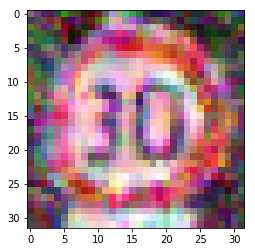

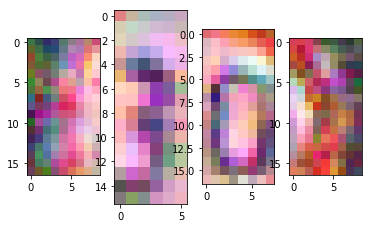

[1.] [0.9844901] [0.98596245] [1.]
[3.9704525]


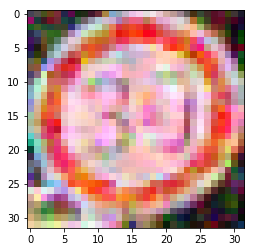

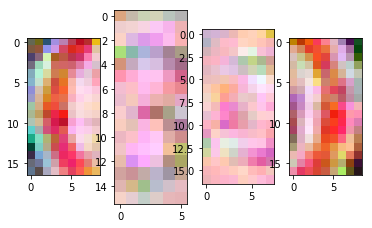

[1.] [0.04921204] [0.99998736] [1.]
[3.0491993]


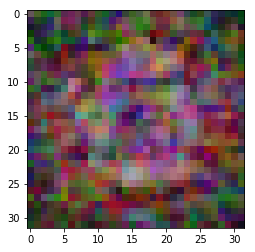

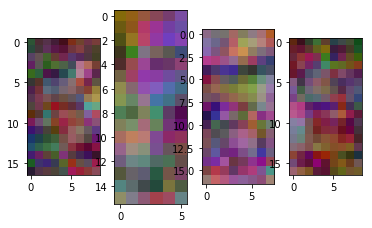

[1.] [0.9986677] [0.98200136] [1.]
[3.980669]


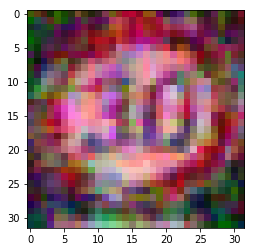

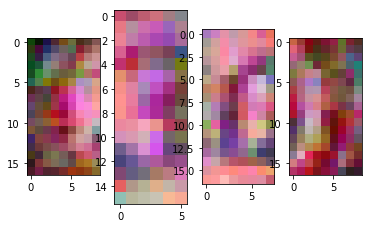

[1.] [1.] [0.04157958] [1.]
[3.0415795]


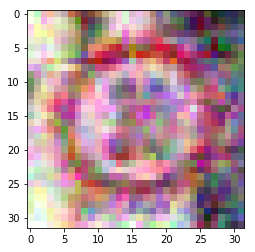

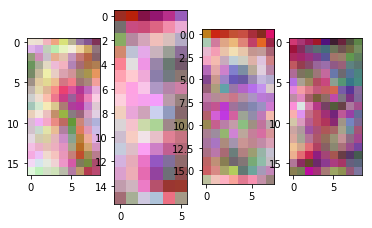

[1.] [0.4694784] [0.98679954] [1.]
[3.4562778]


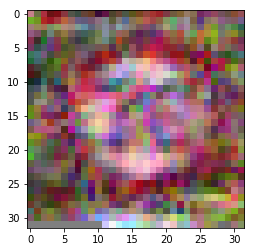

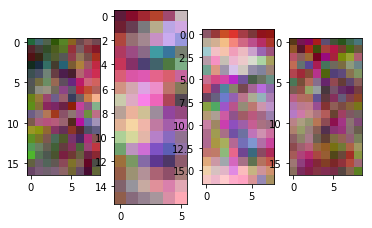

[1.] [0.48896334] [0.99999976] [0.99998987]
[3.488953]


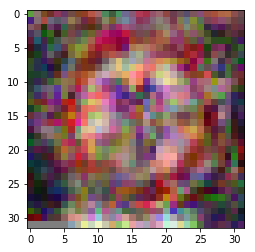

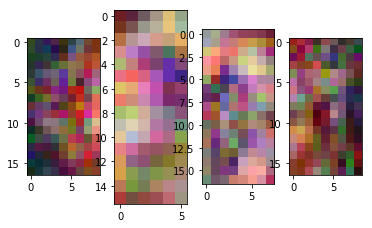

[1.] [0.94589293] [0.99999964] [1.]
[3.9458926]


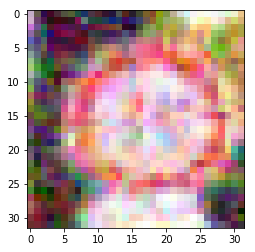

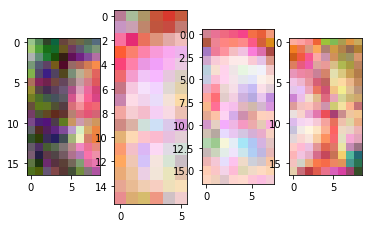

[1.] [0.7477856] [1.] [1.]
[3.7477856]


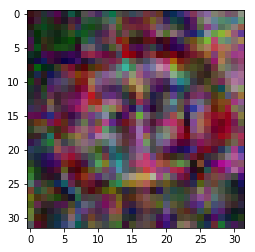

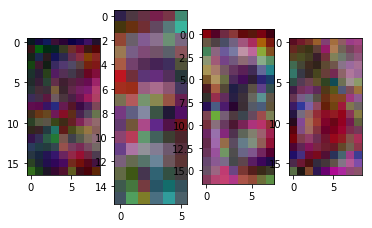

[1.] [1.] [0.01224635] [0.9999988]
[3.0122452]


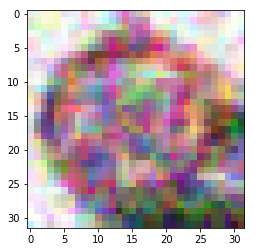

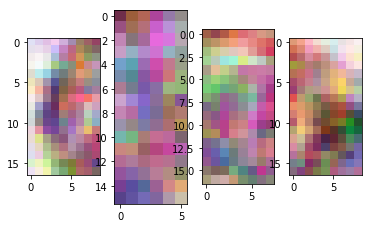

In [45]:
X = adv[:10]
y = featnet.predict_model(sess, X)
ind = np.arange(10)

feed_dict = {featnet.model.get_input_at(0): X[ind]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X[ind]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

X = get_stn_output_v2([X])[0]*0.5 + 0.5
S = get_patch(X, pos_S)
T = get_patch(X, pos_T)
O = get_patch(X, pos_O)
P = get_patch(X, pos_P)

for i, x in enumerate(X[ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[ind][i])
    axs[1].imshow(T[ind][i])
    axs[2].imshow(O[ind][i])
    axs[3].imshow(P[ind][i])
    plt.show()

In [63]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.01,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:715: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-23 05:30:44,416 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [47]:
# (0.5, 0.01, 50)
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  1.0
Attack success on featnet:  0.996
Mean successful l-2 dist:  13.717745
Mean successful l-inf dist:  0.5


In [57]:
# (0.5, 0.01, 50) no rand_init
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.928
Attack success on featnet:  0.892
Mean successful l-2 dist:  4.681041
Mean successful l-inf dist:  0.28332698


In [64]:
# (0.1, 0.01, 50)
y_pred = model.predict(adv)
y_feat = featnet.predict_model(sess, adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(y_feat >= 3))

ind = np.where(y_feat >= 2)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.8
Attack success on featnet:  0.472
Mean successful l-2 dist:  3.9432826
Mean successful l-inf dist:  0.10000003


In [62]:
# (0.1, 0.01, 50) no rand_init
y_pred = model.predict(adv)
y_feat = featnet.predict_model(sess, adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(y_feat >= 3))

ind = np.where(y_feat >= 2)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.74
Attack success on featnet:  0.472
Mean successful l-2 dist:  3.651202
Mean successful l-inf dist:  0.10000004


In [66]:
# Attack on featnet + orig model (L2)

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 5,
              'eps_iter': 0.1,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': 2, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:715: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-23 05:32:15,752 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [67]:
# L2 (5, 0.1, 50)
y_pred = model.predict(adv)
y_feat = featnet.predict_model(sess, adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(y_feat >= 3))

ind = np.where(y_feat >= 2)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.784
Attack success on featnet:  0.156
Mean successful l-2 dist:  4.994913
Mean successful l-inf dist:  0.30877963


In [60]:
# L2 (5, 0.1, 50) no rand_init
y_pred = model.predict(adv)
y_feat = featnet.predict_model(sess, adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(y_feat >= 3))

ind = np.where(y_feat >= 2)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.552
Attack success on featnet:  0.044
Mean successful l-2 dist:  1.4836657
Mean successful l-inf dist:  0.20429601


In [69]:
get_stn_test = K.function([featnet.model.layers[0].input],
                          [featnet.model.layers[3].output])

In [70]:
X_stn = get_stn_test([X_test[:5]])[0]

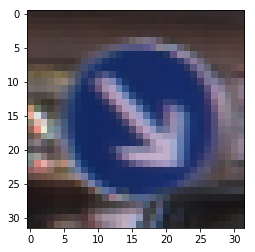

In [71]:
plt.imshow(X_test[2])

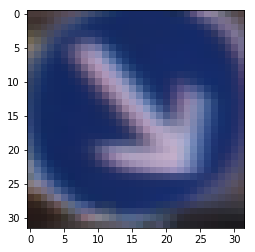

In [72]:
plt.imshow(X_stn[2])

In [19]:
featnet.model.layers[2].set_weights(stn_weight)

### Experiment with no stn

In [22]:
i = np.where(y_test == 14)[0]
X = X_test[i]
np.mean(featnet.predict_model(sess, X) >= 3)

0.9962962962962963

In [23]:
w = featnet.model.get_weights()

In [24]:
from keras.layers import (Activation, Dense, Flatten, Lambda, Conv2D, Input,
                          MaxPooling2D, Reshape, Concatenate, Cropping2D, Add,
                          Dropout)

crop_pos = [pos_S, pos_T, pos_O, pos_P]
feat_scores = []
inpt = Input(shape=(32, 32, 3))
for pos in crop_pos:
    top, bot, left, right = pos
    crop = Cropping2D(((top, 32 - bot), 
                       (left, 32 - right)))(inpt)
    conv2 = Conv2D(32, (3, 3), activation="relu")(crop)
    conv3 = Conv2D(64, (3, 3), activation="relu")(conv2)
    flat = Flatten()(conv3)
    dense1 = Dense(128, activation="relu")(flat)
    drop1 = Dropout(0.25)(dense1)
    dense2 = Dense(32, activation="relu")(drop1)
    drop2 = Dropout(0.5)(dense2)
    dense3 = Dense(1, activation="sigmoid")(drop2)
    feat_scores.append(dense3)
output = Add()(feat_scores)
new_model = keras.models.Model(inputs=inpt, outputs=output)

In [25]:
new_model.set_weights(w[12:])

In [26]:
featnet.model = new_model

In [27]:
i = np.where(y_test == 14)[0]
X = get_stn_output_v2([X_test[i]])[0]*0.5 + 0.5
np.mean(featnet.predict_model(sess, X) >= 3)

0.8851851851851852

In [355]:
n_attack = 250
ind_1 = np.where(y_test == 1)[0]
X = get_stn_output_v2([X_test[ind_1]])[0]*0.5 + 0.5
X_stn = X[:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

In [379]:
# Only attack featnet!!!!

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.5,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 100,
              'rand_init': False,
              'batch_size': n_attack,
              'y_target': y_target}
# wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)
adv = pgd.generate_np(X_stn, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:715: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  "used in the graph computation. They have been "
[INFO 2018-10-23 04:14:17,357 cleverhans] Constructing new graph for attack CustomPGD


In [385]:
i = np.where(y_test == 14)[0]
X = get_stn_output_v2([X_test[i]])[0]*0.5 + 0.5
np.mean(featnet.predict_model(sess, X) >= 3)

0.8851851851851852

In [380]:
# NO rand_init
y_pred = model.predict(adv)
y_feat = featnet.predict_model(sess, adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(y_feat >= 3))

ind = np.where(y_feat >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.0
Attack success on featnet:  0.028
Mean successful l-2 dist:  6.823289
Mean successful l-inf dist:  0.5330247


In [381]:
ind

array([ 30,  41,  45,  75, 101, 115, 153])

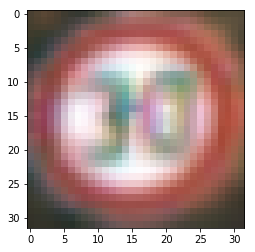

In [378]:
plt.imshow(X_stn[10])

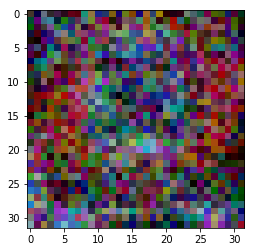

In [375]:
plt.imshow(adv[ind[0]])

# Feature Squeezing

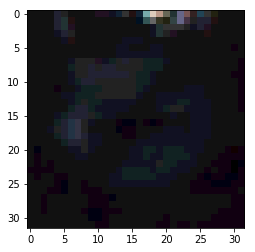

In [46]:
i = 200
plt.imshow(((X_train[i]*15).astype(np.uint8)/15).astype(np.float32))

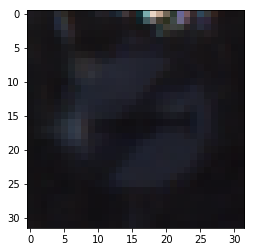

In [34]:
plt.imshow(X_train[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


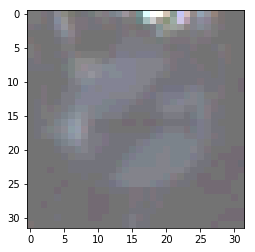

In [47]:
bit = 31
x = np.copy(X_train[200])
x = (x - np.mean(x)) + 0.5
plt.imshow(((x*bit).astype(np.uint8)/bit).astype(np.float32))

In [94]:
from feat_net import FeatNet

featnet = FeatNet("featnet_v9", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-4, 
                  save_path="model/featnet_v9.h5",
                  load_model=True,
                  stn_weight=stn_weight)
bit = 7
data = (((X_train_bal*bit).astype(np.uint8)/bit).astype(np.float32), y_train_bal, 
        ((X_val_bal*bit).astype(np.uint8)/bit).astype(np.float32), y_val_bal)
# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: -0.0849
STEP: 50 	Loss: -1.4284
STEP: 100 	Loss: -1.3856
STEP: 150 	Loss: -1.9486
STEP: 200 	Loss: -1.8617
STEP: 250 	Loss: -1.7417
STEP: 300 	Loss: -2.0046
STEP: 350 	Loss: -1.9194
STEP: 400 	Loss: -1.6466
STEP: 450 	Loss: -2.0060
STEP: 500 	Loss: -1.9823
Train Acc|Loss:	0.9761|-1.9365
Val Acc|Loss:	0.9360|-1.8006
============= EPOCH: 1 =============
STEP: 0 	Loss: -2.0754
STEP: 50 	Loss: -1.5018
STEP: 100 	Loss: -1.8908
STEP: 150 	Loss: -1.7062
STEP: 200 	Loss: -2.0508
STEP: 250 	Loss: -1.9137
STEP: 300 	Loss: -2.1657
STEP: 350 	Loss: -2.3541
STEP: 400 	Loss: -1.8470
STEP: 450 	Loss: -1.8156
STEP: 500 	Loss: -2.0016
Train Acc|Loss:	0.9762|-1.9575
Val Acc|Loss:	0.9360|-1.8206
============= EPOCH: 2 =============
STEP: 0 	Loss: -1.8906
STEP: 50 	Loss: -1.9871
STEP: 100 	Loss: -1.6674
STEP: 150 	Loss: -1.9008
STEP: 200 	Loss: -1.8920
STEP: 250 	Loss: -1.7495
STEP: 300 	Loss: -2.0083
STEP: 350 	Loss: -1.9048
STEP: 400 	Loss: -1.7406
STE

In [95]:
featnet.eval_model(sess, (X_test_bal, y_test_bal))

(0.9239077669902913, -1.7420333483844128)

In [96]:
featnet.eval_model(sess, (((X_test_bal*bit).astype(np.uint8)/bit).astype(np.float32), 
                          y_test_bal))

(0.8960355987055016, -1.8213464619465245)

In [13]:
import logging
from cleverhans.utils import set_log_level
from cleverhans.utils_keras import KerasModelWrapper

# y_train_cat = to_categorical(y_train)
# y_test_cat = to_categorical(y_test)
# y_val_cat = to_categorical(y_val)

n_attack = 250
ind_1 = np.where(y_test == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

In [23]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.01,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=4*.75, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-29 07:52:13,445 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-10-29 07:52:14,540 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-10-29 07:52:14,670 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-29 07:52:16,612 cleverhans]     Iteration 0 of 500: loss=160 l2=0 loss1=8.95e-05
[DEBUG 2018-10-29 07:52:19,891 cleverhans]     Iteration 50 of 500: loss=160 l2=0 loss1=8.95e-05
[DEBUG 2018-10-29 07:52:19,892 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-29 07:52:19,894 cleverhans]   Successfully generated adversarial examples on 0 of 250 instances.
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[DEBUG 2018-10-29 07:52:19,898 cleverhans]    Mean successful dist

In [51]:
y_pred = model.predict(adv)
print("Attack success on orig clf: ", np.mean(np.argmax(y_pred, axis=1) == 14))
print("Attack success on featnet: ", np.mean(featnet.predict_model(sess, adv) >= 3))

ind = np.where(featnet.predict_model(sess, adv) >= 3)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

NameError: name 'adv' is not defined

In [ ]:
bit

In [79]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.01,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    
    adv_sq = ((adv*bit).astype(np.uint8)/bit).astype(np.float32)
    dist_sq = np.sqrt(np.sum((adv_sq - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist_sq))
    
    mo_pred = np.argmax(model.predict(adv_sq), axis=1)
    fn_pred = featnet.predict_model(sess, adv_sq) >= 3
    print(np.mean(fn_pred))
    
    for j in range(n_attack):
        if fn_pred[j] == 1 and mo_pred[j] == 14 and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print("Final")
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/custom_pgd.py:716: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-29 22:50:18,343 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


4.1840487
23.73096
0.168
4.185916
23.731358
0.168
4.1870766
23.733776
0.176
4.187338
23.717087
0.18
4.182619
23.760492
0.192
4.18604
23.727915
0.176
4.18126
23.725515
0.18
4.1851525
23.740984
0.18
4.1829147
23.74843
0.2
4.183708
23.737036
0.188
Final
0.152
4.221333917818572


In [97]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    mo_pred = np.argmax(model.predict(adv), axis=1)
    fn_pred = featnet.predict_model(sess, adv) >= 3
    print(np.mean(fn_pred))
    
    for j in range(n_attack):
        if fn_pred[j] == 1 and mo_pred[j] == 14 and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print("Final")
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/custom_pgd.py:716: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-29 23:13:51,246 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


4.3019123
0.392
4.309363
0.392
4.3076415
0.368
4.306393
0.388
4.3081503
0.38
4.3083878
0.396
4.299348
0.38
4.316616
0.384
4.305345
0.4
4.3008947
0.392
Final
0.424
4.088270437042668


In [98]:
from feat_net import FeatNet

featnetv7 = FeatNet("featnet_v7", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-4, 
                  save_path="model/featnet_v7.h5",
                  load_model=True,
                  stn_weight=stn_weight)

In [99]:
featnetv7.eval_model(sess, (X_test_bal, y_test_bal))

(0.9909385113268608, -1.9731559033050505)

In [100]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnetv7, 4*.75, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    mo_pred = np.argmax(model.predict(adv), axis=1)
    fn_pred = featnetv7.predict_model(sess, adv) >= 3
    print(np.mean(fn_pred))
    
    for j in range(n_attack):
        if fn_pred[j] == 1 and mo_pred[j] == 14 and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print("Final")
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/custom_pgd.py:716: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-29 23:14:56,072 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


4.213913
0.504
4.213228
0.532
4.2118535
0.512
4.212983
0.532
4.2170634
0.524
4.2067413
0.52
4.2143087
0.504
4.205283
0.524
4.2174726
0.536
4.221294
0.552
Final
0.56
4.012395393848419


# Dim Red

In [113]:
X_stn = get_stn_output_v2([X_train[y_train == 14][:200]])[0]
X_S = get_patch(X_stn, pos_S)*0.5 + 0.5

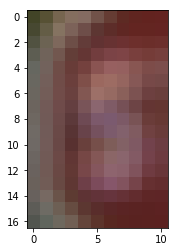

In [140]:
plt.imshow(X_S[150])

In [115]:
X_S.shape

(200, 17, 11, 3)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:812: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  warn("Bi-quadratic interpolation behavior has changed due "


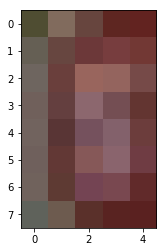

In [129]:
from skimage.transform import resize
x = resize(X_S[150], (8, 5), order=2)
plt.imshow(x)

In [132]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train.reshape(-1, 3072))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [135]:
np.cumsum(pca.explained_variance_ratio_) > 0.99

array([False, False, False, ...,  True,  True,  True])

In [9]:
from skimage import exposure

i = 0

x = np.copy(X_train[y_train == 14][i])
x = get_stn_output_v2([x[np.newaxis]])[0]*0.5 + 0.5
plt.imshow(x[0])
plt.show()
plt.imshow(get_patch(x, pos_S)[0])
plt.show()

x = np.copy(X_train[y_train == 14][i])

# x = exposure.rescale_intensity(x)

# v_min, v_max = np.percentile(x, (10, 90))
# print(np.min(x), np.max(x))
# print(v_min, v_max)
# x = exposure.rescale_intensity(x, in_range=(v_min, v_max))

# x = exposure.equalize_adapthist(x, kernel_size=None, clip_limit=0.1)

x = exposure.equalize_hist(x)

x = get_stn_output_v2([x[np.newaxis]])[0]*0.5 + 0.5
plt.imshow(x[0])
plt.show()
plt.imshow(get_patch(x, pos_S)[0])
plt.show()

NameError: name 'get_stn_output_v2' is not defined

In [167]:
X_train = exposure.equalize_hist(X_train)

/usr/local/lib/python3.5/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


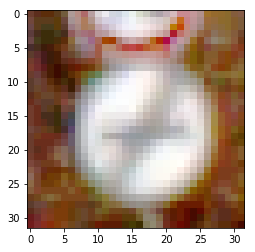

In [168]:
plt.imshow(x)

In [39]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_hist.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[2].output])
get_stn_output_v2 = K.function([model.layers[0].input], [model.layers[2].output])
stn_weight = model.layers[2].get_weights()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

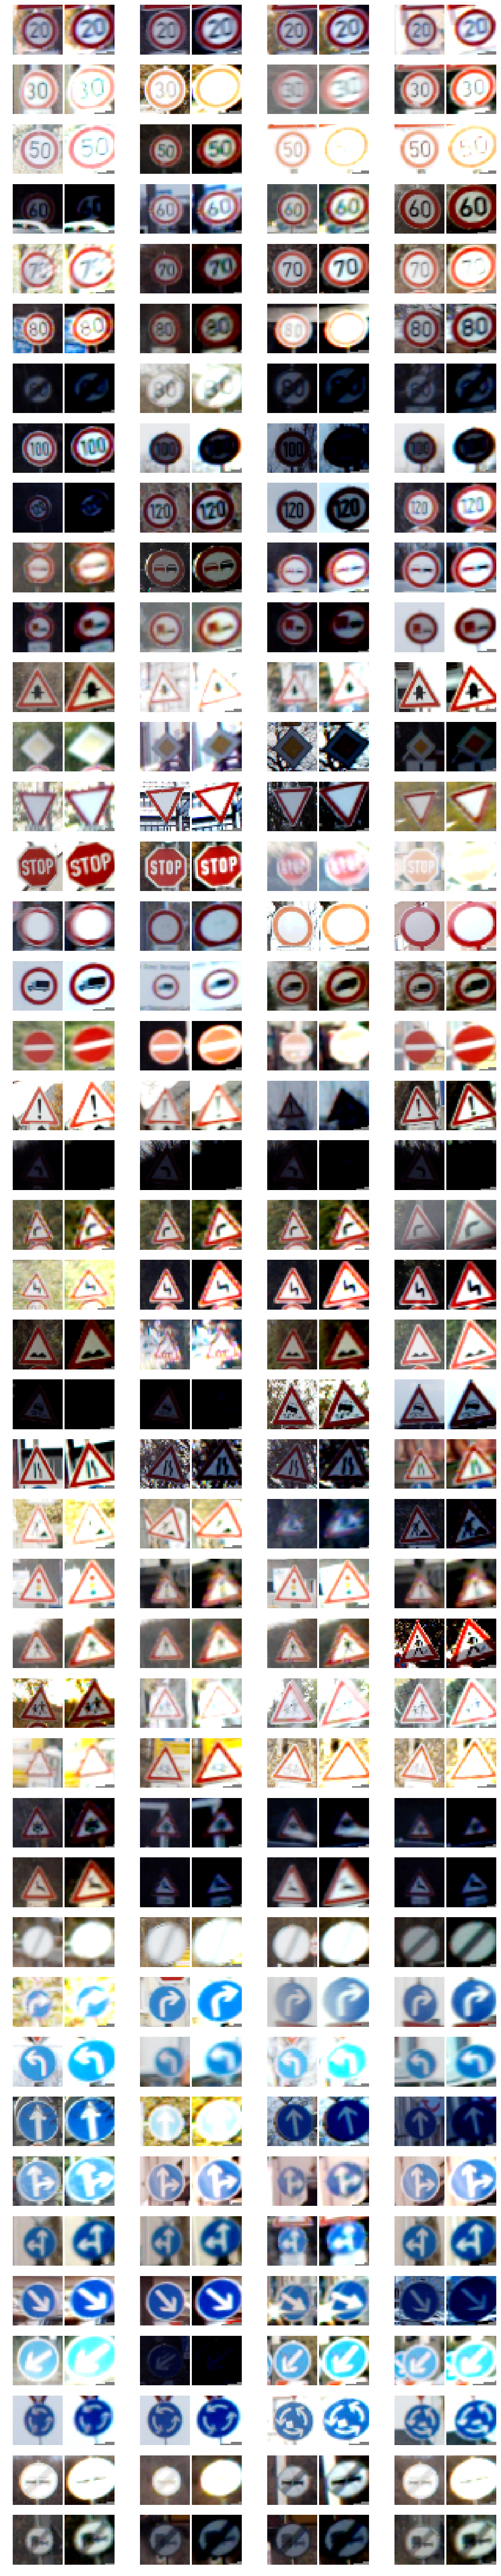

In [42]:
X = exposure.equalize_hist(X_test)
y = y_test

# f, ax = plt.subplots(NUM_LABELS, 8, figsize=(20, 60))
fig = plt.figure(figsize=(15, 100))

for j in range(4):
    
    left = j*0.25 + 0.05
    right = j*0.25 + 0.25
    gs = GridSpec(NUM_LABELS, 2)
    gs.update(left=left, right=right, wspace=0.05)
    for i in range(NUM_LABELS):

        ind = np.where(y == i)
        ax1 = plt.subplot(gs[i, 0])
        ax2 = plt.subplot(gs[i, 1])
        
        x = X[ind][j]
        ax1.imshow(x)
        ax1.axis("off")

        stn_output = get_stn_output_v2([x[np.newaxis, :]])[0]*0.5 + 0.5
        x = np.copy(stn_output[0])
        # x = (x - x.min())/(x.max() - x.min())
#         for c in range(3):
#             x_c = x[:, :, c]
#             x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
        ax2.imshow(x)
        ax2.axis("off")
        
# plt.savefig("stn_v3.png", bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

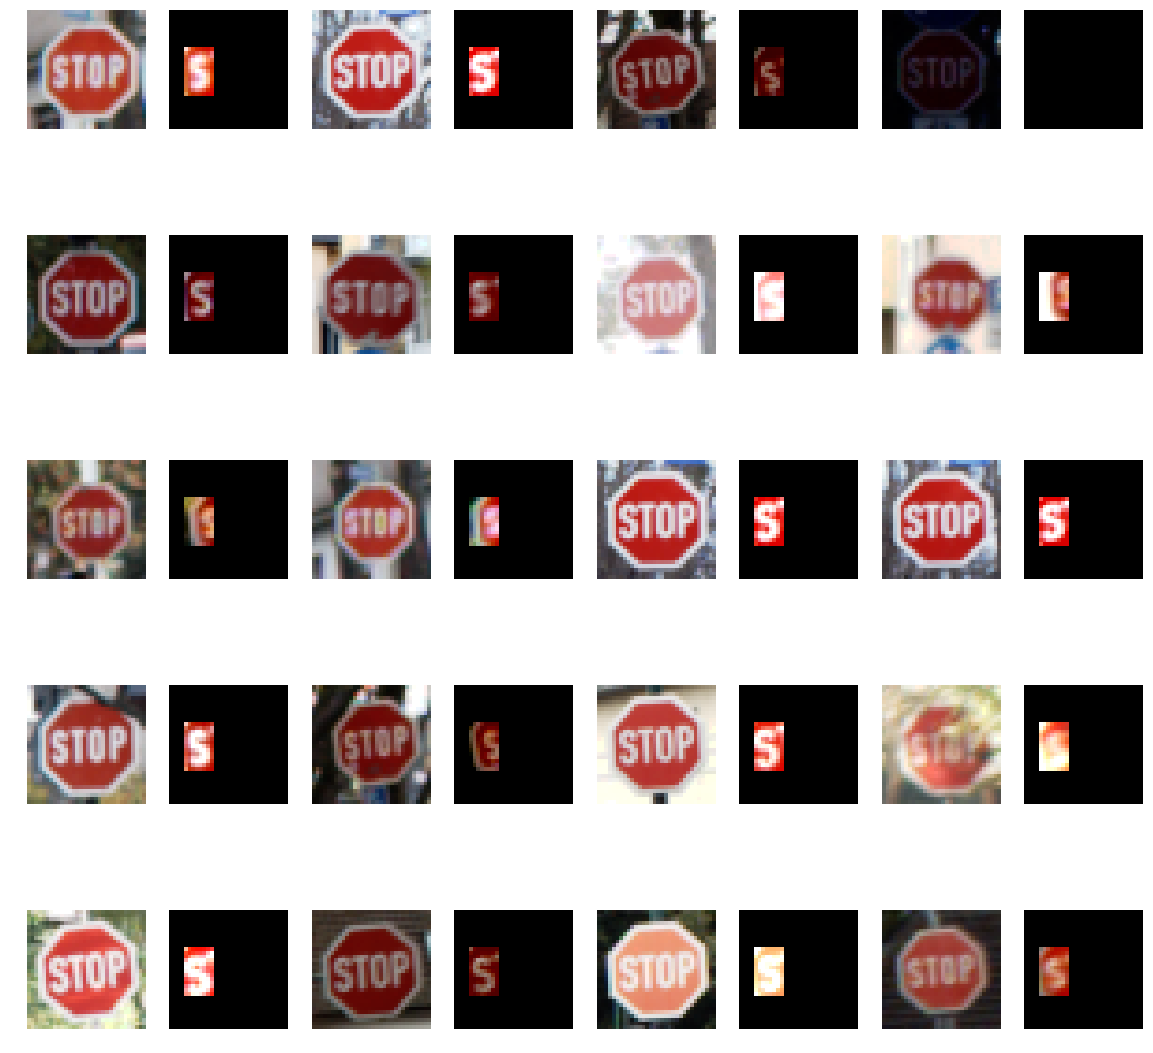

In [50]:
X = exposure.equalize_hist(X_train[y_train == 14])
y = y_train
n = 20
top, bot, left, right = 10, 23, 4, 12
ind = np.arange(len(X))
random.shuffle(ind)

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 20))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[ind][i]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    stn_output = get_stn_output_v2([x[np.newaxis, :]])[0]
    x = np.copy(stn_output[0])*0.5 + 0.5
    # x = (x - x.min())/(x.max() - x.min())
#     for c in range(3):
#         x_c = x[:, :, c]
#         x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
#     ax[ii, jj].imshow(x)
#     ax[ii, jj].axis("off")
    
    x[:top, :] = 0
    x[bot:, :] = 0
    x[:, :left] = 0
    x[:, right:] = 0
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")

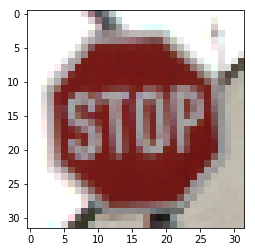

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


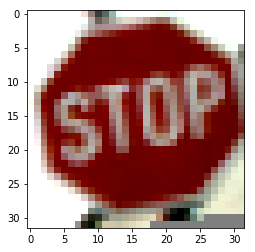

In [44]:
x = exposure.equalize_hist(X_test[y_test == 14])
plt.imshow(x[0])
plt.show()

x = get_stn_output_v2([x])[0]*0.5 + 0.5
plt.imshow(x[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


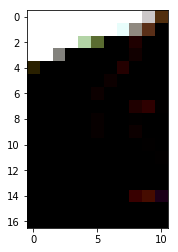

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


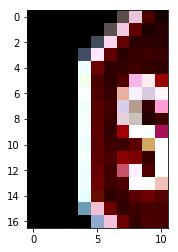

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


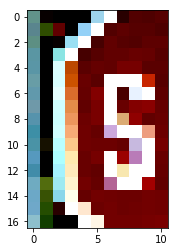

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


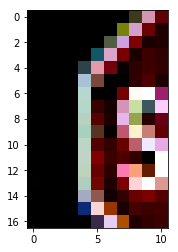

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


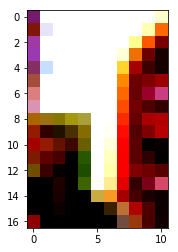

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


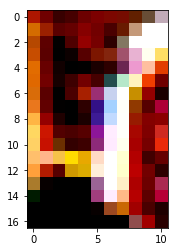

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


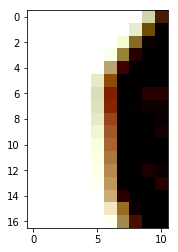

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


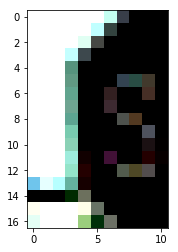

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


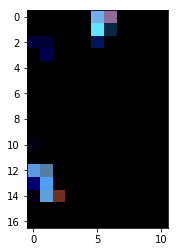

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


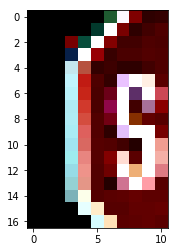

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


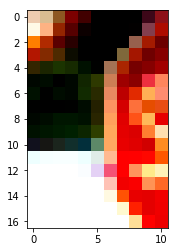

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


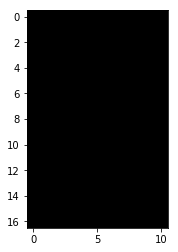

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


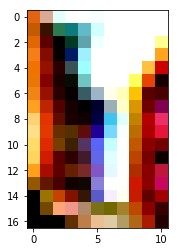

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


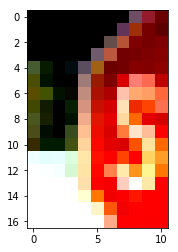

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


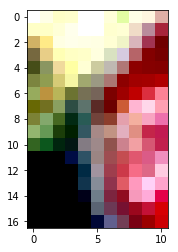

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


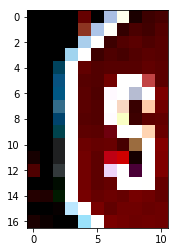

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


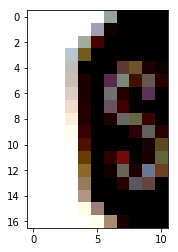

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


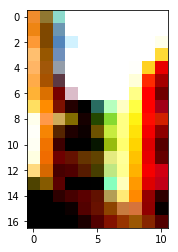

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


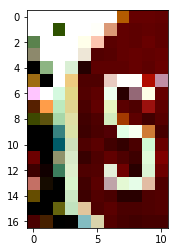

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


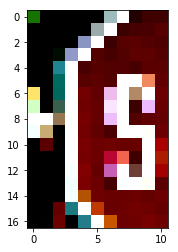

In [34]:
x = get_stn_output_v2([exposure.equalize_hist(X_test[y_test == 14])])[0]*0.5 + 0.5
pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)
x = get_patch(x, pos_S)
ind = np.random.choice(len(x), 20)
for i in ind:
    plt.imshow(x[i])
    plt.show()

In [11]:
X_train_hist = exposure.equalize_hist(X_train_bal)
X_val_hist = exposure.equalize_hist(X_val_bal)
X_test_hist = exposure.equalize_hist(X_test_bal)

In [16]:
from feat_net import FeatNet

featnet = FeatNet("featnet_v10", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-3, 
                  save_path="model/featnet_v10.h5",
                  load_model=False,
                  stn_weight=stn_weight)
data = (X_train_hist, y_train_bal, X_val_hist, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.2366
STEP: 50 	Loss: -2.0595
STEP: 100 	Loss: -1.8945
STEP: 150 	Loss: -1.8702
STEP: 200 	Loss: -1.8474
STEP: 250 	Loss: -2.3802
STEP: 300 	Loss: -1.8910
STEP: 350 	Loss: -2.1776
STEP: 400 	Loss: -1.8417
STEP: 450 	Loss: -2.1641
STEP: 500 	Loss: -2.0787
Train Acc|Loss:	0.9973|-1.9765
Val Acc|Loss:	0.9860|-1.9436
============= EPOCH: 1 =============
STEP: 0 	Loss: -2.0151
STEP: 50 	Loss: -1.8493
STEP: 100 	Loss: -1.9467
STEP: 150 	Loss: -2.1009
STEP: 200 	Loss: -2.2154
STEP: 250 	Loss: -2.0416
STEP: 300 	Loss: -1.7481
STEP: 350 	Loss: -1.9144
STEP: 400 	Loss: -2.0196
STEP: 450 	Loss: -1.8123
STEP: 500 	Loss: -1.8427
Train Acc|Loss:	0.9973|-1.9947
Val Acc|Loss:	0.9832|-1.9565
============= EPOCH: 2 =============
STEP: 0 	Loss: -2.2108
STEP: 50 	Loss: -2.1770
STEP: 100 	Loss: -1.9594
STEP: 150 	Loss: -1.9343
STEP: 200 	Loss: -1.8353
STEP: 250 	Loss: -1.9050
STEP: 300 	Loss: -1.5550
STEP: 350 	Loss: -2.3747
STEP: 400 	Loss: -1.7032
STEP

In [18]:
featnet.eval_model(sess, (X_val_hist, y_val_bal))

(0.9945601851851852, -1.9704882806649915)

In [19]:
featnet.eval_model(sess, (X_test_hist, y_test_bal))

(0.933373786407767, -1.8565325460773456)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.9999999] [0.9805931] [0.00312539] [0.9718937]
[2.9556122]


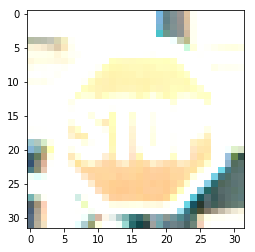

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


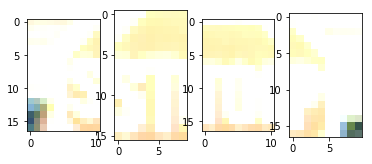

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4.6287965e-08] [0.99999785] [0.99999726] [0.9999926]
[2.9999878]


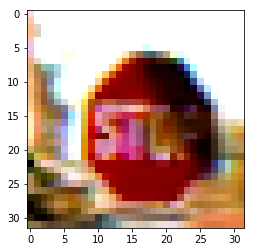

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


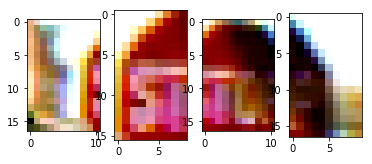

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.99999964] [0.9340155] [0.00051109] [0.9998419]
[2.9343681]


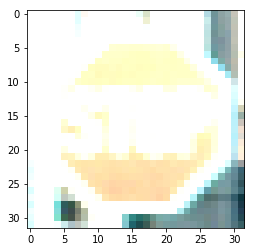

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


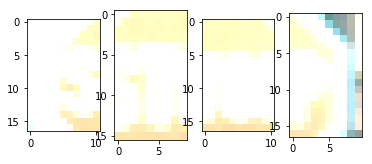

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.9980123] [0.1713525] [0.29676157] [0.07892719]
[1.5450536]


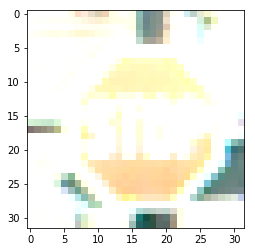

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


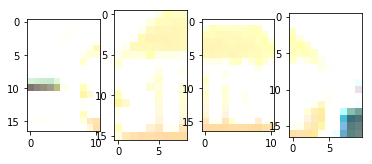

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.99998116] [0.00049913] [0.99409455] [0.9989862]
[2.993561]


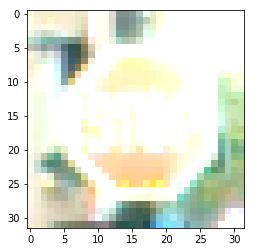

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


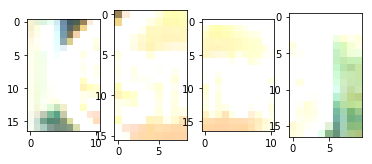

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.99999666] [0.75255036] [0.00594538] [0.9992118]
[2.7577043]


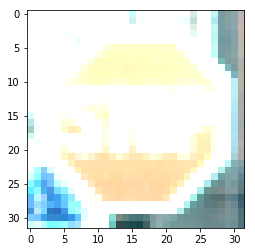

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


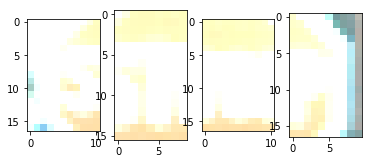

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.9616431] [0.02607696] [7.547658e-06] [0.9967713]
[1.984499]


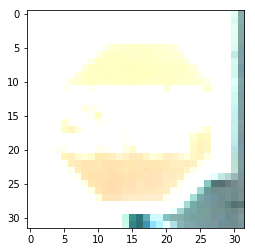

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


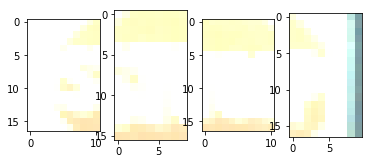

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.9999995] [0.9637943] [0.01209639] [0.99482745]
[2.9707177]


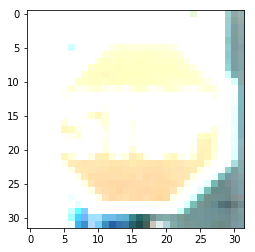

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


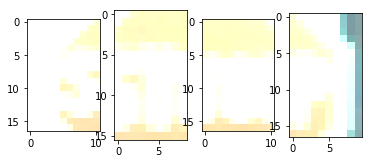

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.8713179] [0.00017884] [3.0640127e-05] [0.9999994]
[1.8715268]


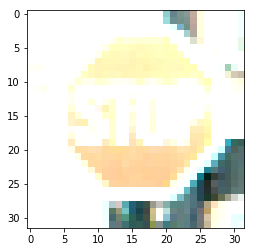

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


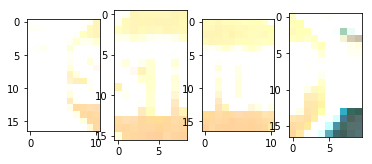

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6.768495e-07] [0.94846696] [0.9999275] [0.99997735]
[2.9483724]


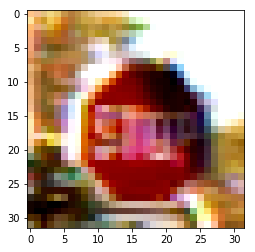

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


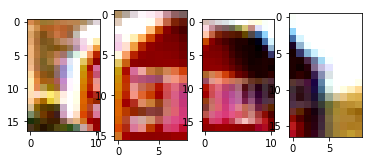

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.99999964] [0.9171424] [0.03815736] [0.9999956]
[2.955295]


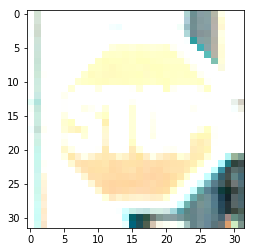

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


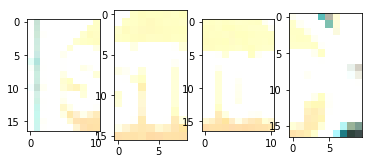

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5.4056684e-08] [0.22734345] [0.9999981] [1.]
[2.2273417]


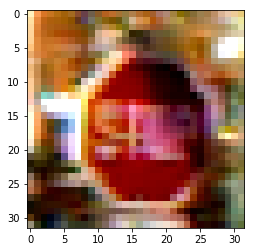

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


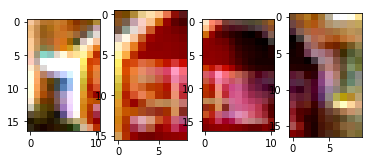

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00012469] [0.987063] [1.] [1.]
[2.9871876]


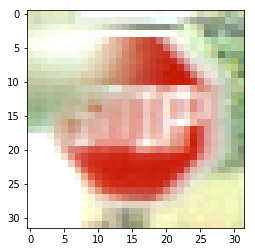

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


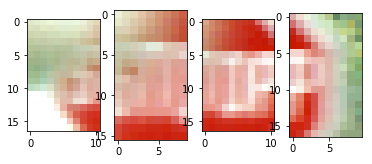

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7.588542e-07] [0.9990637] [0.9999995] [0.9999999]
[2.999064]


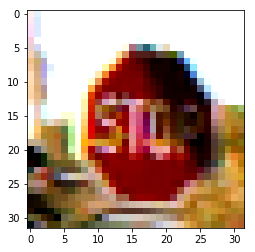

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


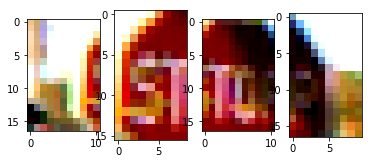

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.] [0.99032485] [0.00257024] [0.99947935]
[2.9923744]


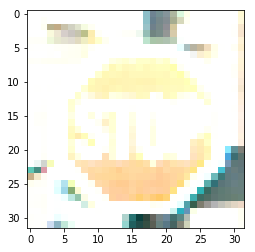

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


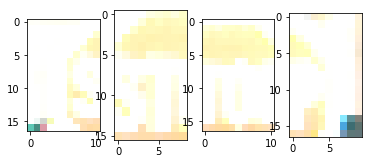

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5.311462e-10] [0.8643036] [0.9932847] [0.47583437]
[2.3334227]


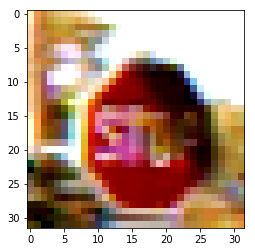

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


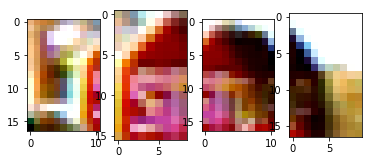

In [33]:
X = exposure.equalize_hist(X_test[y_test == 14])

y = featnet.predict_model(sess, X)
ind = np.where(y < 4*0.75)[0]

feed_dict = {featnet.model.get_input_at(0): X[ind]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X[ind]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

X = get_stn_output_v2([X])[0]*0.5 + 0.5
S = get_patch(X, pos_S)
T = get_patch(X, pos_T)
O = get_patch(X, pos_O)
P = get_patch(X, pos_P)

for i, x in enumerate(X[ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[ind][i])
    axs[1].imshow(T[ind][i])
    axs[2].imshow(O[ind][i])
    axs[3].imshow(P[ind][i])
    plt.show()

In [ ]:
import logging
from cleverhans.utils import set_log_level
from cleverhans.utils_keras import KerasModelWrapper

# y_train_cat = to_categorical(y_train)
# y_test_cat = to_categorical(y_test)
# y_val_cat = to_categorical(y_val)

n_attack = 250
ind_1 = np.where(y_test == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

---
# 9: Test Histogram Equalization & Color Threshold

In [168]:
import skimage

def rgb_to_ycc(X):
    
    if np.ndim(X) == 3:
        imgs = X[np.newaxis]
    else:
        imgs = X
    output = np.zeros_like(imgs)
    for i, img in enumerate(imgs):
        img_ycc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#         img_ycc[:, :, 0] = skimage.exposure.equalize_adapthist(img_ycc[:, :, 0])
        img_ycc[:, :, 0] = skimage.exposure.equalize_hist(img_ycc[:, :, 0])
        img_output = cv2.cvtColor(img_ycc, cv2.COLOR_YCrCb2RGB)
        output[i] = img_output
    if np.ndim(X) == 3:
        return output[0]
    else:
        return output
    
def hue_thres(x, start, end):
    hsv = matplotlib.colors.rgb_to_hsv(x)
    if start <= end:
        h = np.logical_and(hsv[:, :, 0] >= start, hsv[:, :, 0] <= end)
    else:
        h = np.logical_and(hsv[:, :, 0] >= start, 1 - hsv[:, :, 0] <= end)
    return h

def hue_dist(x, mid, width, s_thres=0, v_thres=0):
    hsv = matplotlib.colors.rgb_to_hsv(x)
    h = hsv[:, :, 0]
    s = hsv[:, :, 1] >= s_thres
    v = hsv[:, :, 2] >= v_thres
    
    dist1 = np.abs(h - mid)
    dist2 = np.abs(h + 1 - mid)
    dist3 = np.abs(h - mid - 1)
    dist = np.minimum(dist1, dist2)
    dist = np.minimum(dist, dist3)
    out = 1 - dist / width
    out[out < 0] = 0
    out = out * s * v
    return out

In [93]:
X_train_ycc = rgb_to_ycc(X_train)
X_test_ycc = rgb_to_ycc(X_test)
X_val_ycc = rgb_to_ycc(X_val)

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow 

13399
34585
1655
27256
32034
12651
8352
29124
9109
27785
18432
5930
19160
13133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4038
12493
2963
9283
22403
8785


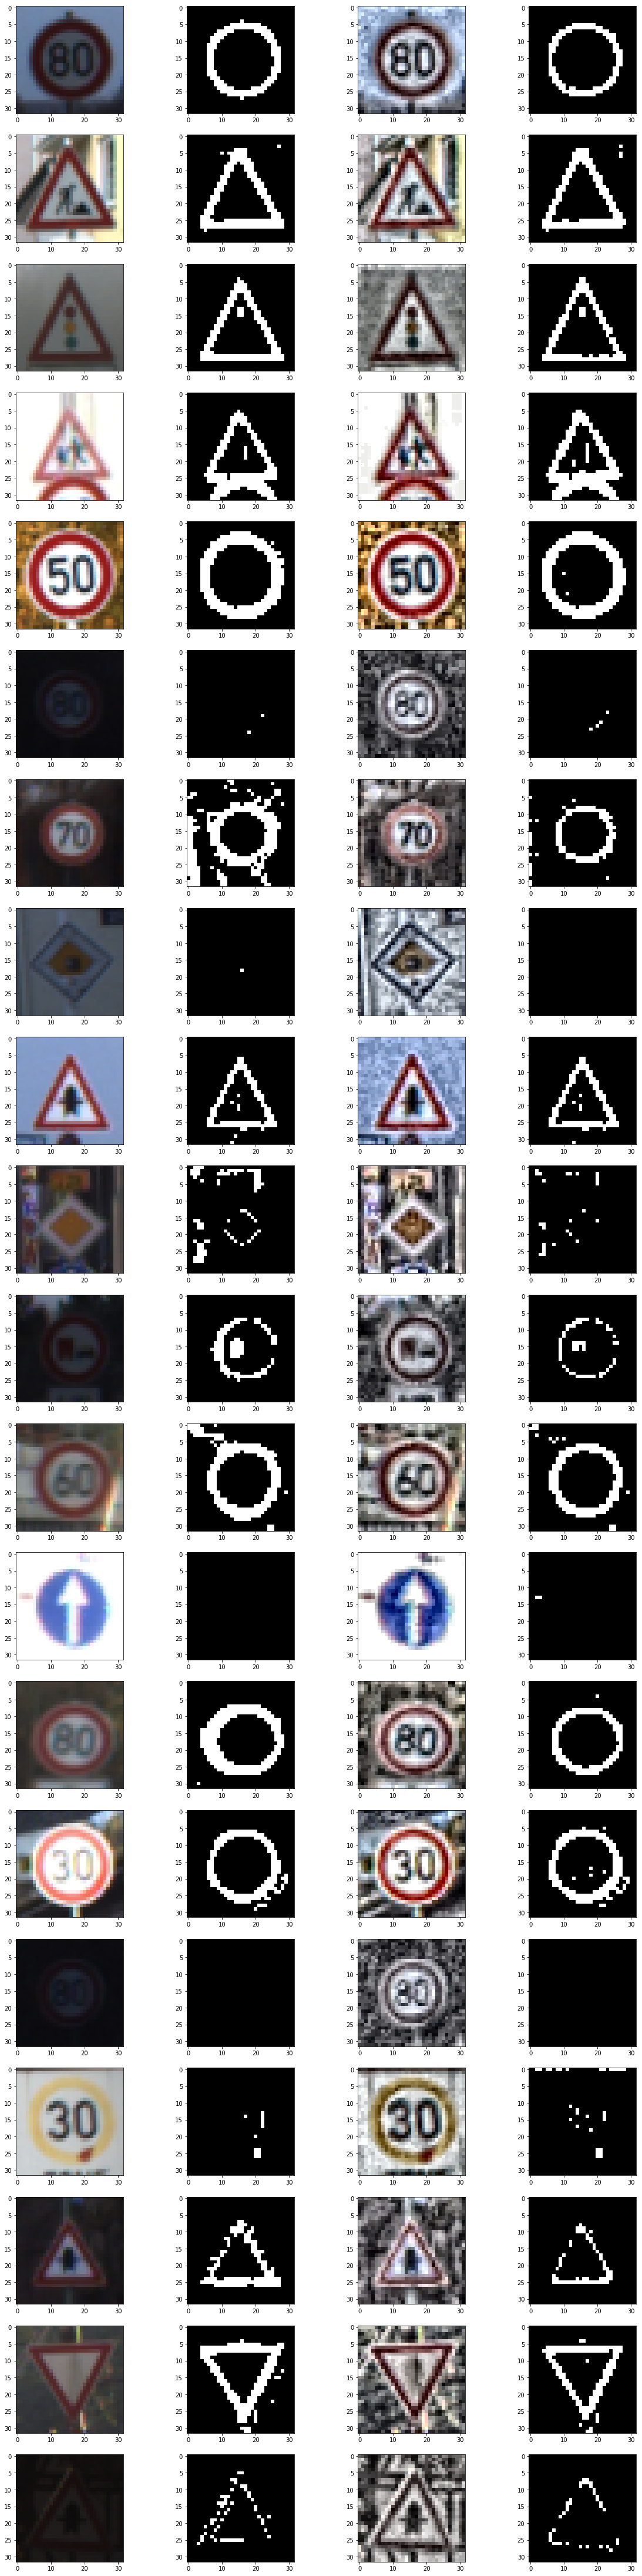

In [152]:
ind = np.random.choice(len(X_train), 20)
fig, axes = plt.subplots(20, 4, figsize=(20, 80))
for ii, i in enumerate(ind): 
    print(i)
    axes[ii, 0].imshow(X_train[i])
    axes[ii, 1].imshow(hue_dist(X_train[i], 0, 0.1, 0.2, 0.1), cmap='gray')
    x = rgb_to_ycc(X_train[i])
    axes[ii, 2].imshow(x)
    axes[ii, 3].imshow(hue_dist(x, 0, 0.1, 0.2, 0.1), cmap='gray')

In [100]:
pickle.dump(X_train_ycc, open("X_train_ycc.p", "wb"))
pickle.dump(X_test_ycc, open("X_test_ycc.p", "wb"))
pickle.dump(X_val_ycc, open("X_val_ycc.p", "wb"))

In [166]:
def yuv_dist(x, u_range, v_range):
    yuv = cv2.cvtColor(x, cv2.COLOR_RGB2YUV)
    y = yuv[:, :, 0]
    return y >= 0.8
#     u = np.logical_and(yuv[:, :, 1] >= u_range[0], yuv[:, :, 1] <= u_range[1])
#     v = np.logical_and(yuv[:, :, 2] >= v_range[0], yuv[:, :, 2] <= v_range[1])
#     return np.logical_and(u, v)

def rgb_thres(x, thres):
    add = np.sum(x, axis=-1)
    return add >= thres

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

8849
29806
10902
25437
10113
30841
31235
10429
16525
27484
10958
33879
13554
2404
20335
28475
6660
5583
357
21230


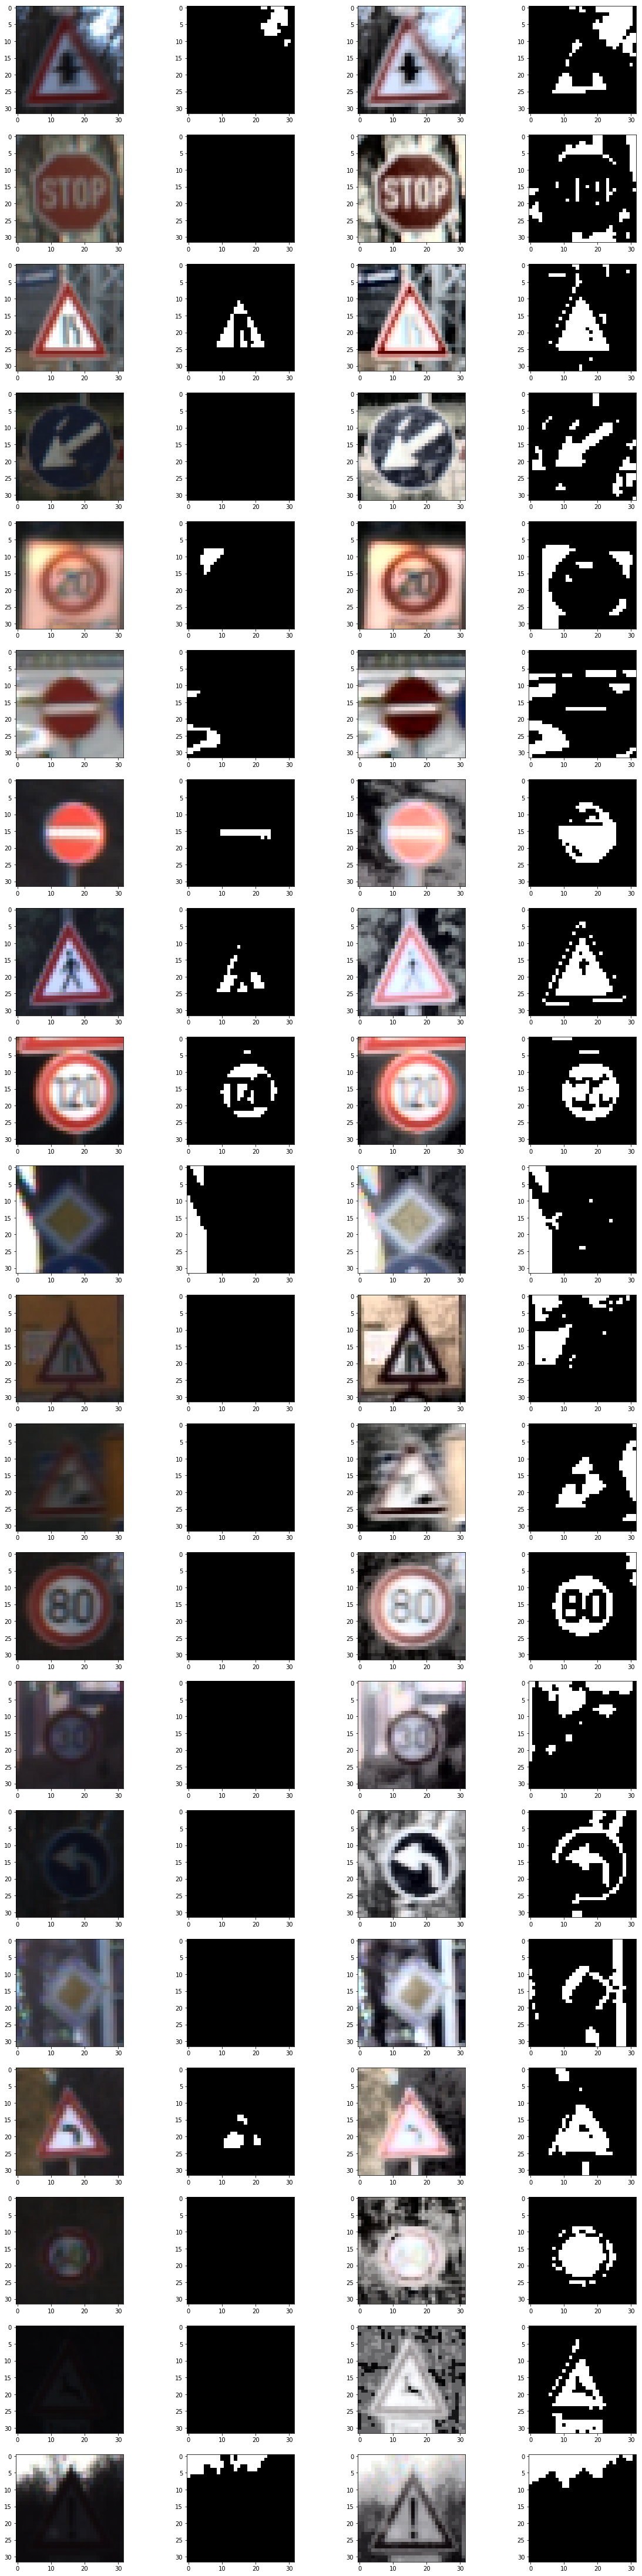

In [169]:
ind = np.random.choice(len(X_train), 20)
fig, axes = plt.subplots(20, 4, figsize=(20, 80))
for ii, i in enumerate(ind): 
    print(i)
    axes[ii, 0].imshow(X_train[i])
#     axes[ii, 1].imshow(yuv_dist(X_train[i], [0, 0.5], [0.5, 1]), cmap='gray')
    axes[ii, 1].imshow(rgb_thres(X_train[i], 2.5), cmap='gray')
    x = rgb_to_ycc(X_train[i])
    axes[ii, 2].imshow(x)
    axes[ii, 3].imshow(rgb_thres(x, 2.5), cmap='gray')

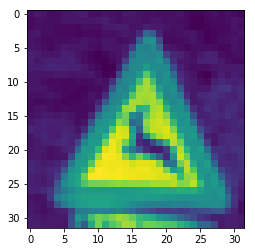

In [175]:
plt.imshow(X_train[500, :, :, 0])

---

# Attack original model (STN)

In [109]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from cleverhans.attacks import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CarliniWagnerL2(wrap_clf, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 05:20:42,142 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-16 05:20:45,820 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-10-16 05:20:46,425 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 05:20:48,424 cleverhans]     Iteration 0 of 200: loss=3.69e+04 l2=0 f=-1.81
[DEBUG 2018-10-16 05:20:50,975 cleverhans]     Iteration 20 of 200: loss=5.03e+03 l2=19.7 f=-0.3
[DEBUG 2018-10-16 05:20:53,563 cleverhans]     Iteration 40 of 200: loss=2.39e+03 l2=9.16 f=-0.524
[DEBUG 2018-10-16 05:20:56,097 cleverhans]     Iteration 60 of 200: loss=2e+03 l2=7.63 f=-0.623
[DEBUG 2018-10-16 05:20:58,583 cleverhans]     Iteration 80 of 200: loss=1.99e+03 l2=7.67 f=-0.659
[DEBUG 2018-10-16 05:21:01,077 cleverhans]     Iteration 100 of 200: loss=2.1e+03 l2=8.17 f=-0.703
[DEBUG 2018-10-16 05:21:01,078 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-16 05:21:01,083 cleverhans]   Successfully generated adversarial exampl

In [110]:
y_pred = model.predict(adv)
np.mean(np.argmax(y_pred, axis=1) == 14)

0.984

In [111]:
feed_dict = {featnet.x: adv}
out = sess.run(featnet.output, feed_dict=feed_dict)
np.mean(out >= 3)

0.0

[0.] [0.] [0.] [0.]
[0.]


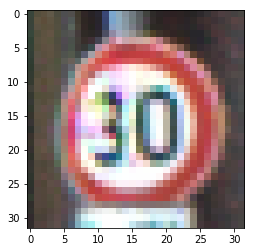

[0.] [0.] [0.] [0.]
[0.]


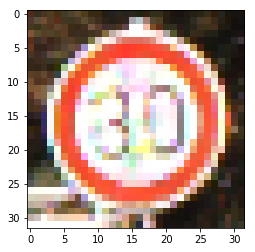

[7.806256e-27] [1.0924627e-18] [0.] [2.3121208e-15]
[2.3132133e-15]


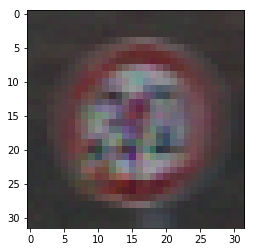

[0.] [0.] [0.] [0.]
[0.]


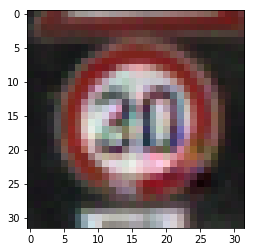

[0.] [0.] [0.] [0.]
[0.]


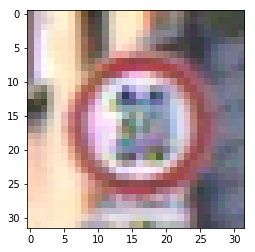

[0.] [0.] [0.] [1.2801619e-37]
[1.2801619e-37]


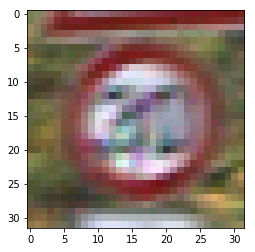

[4.713016e-36] [8.3346595e-22] [0.] [7.1654096e-22]
[1.5500069e-21]


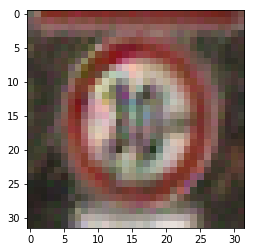

[0.] [0.] [0.] [0.]
[0.]


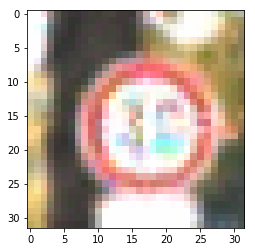

[1.985574e-25] [1.6495492e-18] [0.] [3.1207528e-20]
[1.680757e-18]


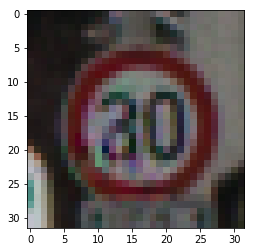

[0.] [2.6027576e-34] [0.] [1.2462754e-34]
[3.849033e-34]


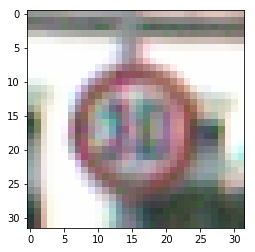

In [112]:
X = adv[np.argmax(y_pred, axis=1) == 14][:10]

feed_dict = {featnet.model.get_input_at(0): X}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

for i, x in enumerate(X):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

---
# 10: featnet_v7 with color thres

In [154]:
def hue_dist_all(X, mid, width, s_thres=0, v_thres=0):
    hsv = matplotlib.colors.rgb_to_hsv(x)

    h = hsv[:, :, :, 0]
    s = hsv[:, :, :, 1] >= s_thres
    v = hsv[:, :, :, 2] >= v_thres
    
    dist1 = np.abs(h - mid)
    dist2 = np.abs(h + 1 - mid)
    dist3 = np.abs(h - mid - 1)
    dist = np.minimum(dist1, dist2)
    dist = np.minimum(dist, dist3)
    out = 1 - dist / width
    out[out < 0] = 0
    out = out * s * v
    return out

In [ ]:
X_train_thres = hue_dist_all(X_train_bal, 0, 0.1, 0.2, 0.1)
X_val_thres = hue_dist_all(X_train_bal, 0, 0.1, 0.2, 0.1)
X_train_bal, y_train_bal, X_val_bal, y_val_bal

In [ ]:
from feat_net import FeatNet

featnet = FeatNet("featnet_v10", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=5e-4, 
                  save_path="model/featnet_v10.h5",
                  load_model=True,
                  stn_weight=stn_weight)

data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, n_epoch=10, batch_size=128)